In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (Xception notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
# Adding the top layer
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-xception-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [11]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.0137
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 156s - loss: 0.6031 - acc: 0.8256 - val_loss: 1.3014 - val_acc: 0.6660
Epoch 2/100
9112/9112 [==============================] - 158s - loss: 0.3227 - acc: 0.9014 - val_loss: 0.4415 - val_acc: 0.8857
Epoch 3/100
9112/9112 [==============================] - 161s - loss: 0.2246 - acc: 0.9302 - val_loss: 0.4265 - val_acc: 0.8945
Epoch 4/100
9112/9112 [==============================] - 153s - loss: 0.1778 - acc: 0.9444 - val_loss: 1.0333 - val_acc: 0.7188
Epoch 5/100
9112/9112 [==============================] - 158s - loss: 0.1538 - acc: 0.9502 - val_loss: 1.4177 - val_acc: 0.6660
Epoch 6/100
9112/9112 [==============================] - 157s - loss: 0.1354 - acc: 0.9602 - val_loss: 0.3123 - val_acc: 0.9131
Epoch 7/100
9112/9112 [==============================] - 160s - loss: 0.0832 - acc: 0.9717 - val_loss: 0.2786 - val_acc: 0.9238
Epoch 8/100
9112/9112 [====

9114/9114 [==============================] - 137s - loss: 0.0502 - acc: 0.9843 - val_loss: 0.6922 - val_acc: 0.8757
Epoch 26/100
9114/9114 [==============================] - 136s - loss: 0.0271 - acc: 0.9905 - val_loss: 0.5607 - val_acc: 0.9119
Epoch 27/100
9114/9114 [==============================] - 136s - loss: 0.0249 - acc: 0.9924 - val_loss: 0.4289 - val_acc: 0.9207
Epoch 28/100
9114/9114 [==============================] - 137s - loss: 0.0145 - acc: 0.9962 - val_loss: 0.4848 - val_acc: 0.9090
Epoch 29/100
9114/9114 [==============================] - 136s - loss: 0.0179 - acc: 0.9943 - val_loss: 0.4263 - val_acc: 0.9207
Epoch 30/100
9114/9114 [==============================] - 136s - loss: 0.0208 - acc: 0.9928 - val_loss: 0.8240 - val_acc: 0.8444
Epoch 31/100
9114/9114 [==============================] - 137s - loss: 0.0362 - acc: 0.9887 - val_loss: 0.5381 - val_acc: 0.9315
Epoch 32/100
9114/9114 [==============================] - 136s - loss: 0.0209 - acc: 0.9941 - val_loss: 0.4754

9116/9116 [==============================] - 136s - loss: 0.0173 - acc: 0.9939 - val_loss: 0.5863 - val_acc: 0.8931
Epoch 51/100
9116/9116 [==============================] - 136s - loss: 0.0168 - acc: 0.9941 - val_loss: 0.4336 - val_acc: 0.9324
Epoch 52/100
9116/9116 [==============================] - 136s - loss: 0.0097 - acc: 0.9970 - val_loss: 0.4217 - val_acc: 0.9314
Epoch 53/100
9116/9116 [==============================] - 136s - loss: 0.0028 - acc: 0.9990 - val_loss: 0.4907 - val_acc: 0.9265
Epoch 54/100
9116/9116 [==============================] - 136s - loss: 0.0135 - acc: 0.9958 - val_loss: 0.4704 - val_acc: 0.9196
Epoch 55/100
9116/9116 [==============================] - 136s - loss: 0.0107 - acc: 0.9965 - val_loss: 0.7682 - val_acc: 0.8912
Epoch 56/100
9116/9116 [==============================] - 137s - loss: 0.0149 - acc: 0.9955 - val_loss: 0.4888 - val_acc: 0.9304
Epoch 57/100
9116/9116 [==============================] - 137s - loss: 0.0166 - acc: 0.9952 - val_loss: 0.5785

9120/9120 [==============================] - 136s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.5585 - val_acc: 0.9252
Epoch 76/100
9120/9120 [==============================] - 136s - loss: 0.0018 - acc: 0.9997 - val_loss: 0.5802 - val_acc: 0.9222
Epoch 77/100
9120/9120 [==============================] - 137s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.5963 - val_acc: 0.9252
Epoch 78/100
9120/9120 [==============================] - 136s - loss: 0.0224 - acc: 0.9944 - val_loss: 4.3515 - val_acc: 0.6083
Epoch 79/100
9120/9120 [==============================] - 137s - loss: 0.0336 - acc: 0.9905 - val_loss: 0.7317 - val_acc: 0.8868
Epoch 80/100
9120/9120 [==============================] - 137s - loss: 0.0097 - acc: 0.9964 - val_loss: 0.6658 - val_acc: 0.9213
Epoch 81/100
9120/9120 [==============================] - 137s - loss: 0.0023 - acc: 0.9993 - val_loss: 0.5343 - val_acc: 0.9213
Epoch 82/100
9120/9120 [==============================] - 136s - loss: 0.0016 - acc: 0.9996 - val_loss: 0.5559

1016/1016 [==============================] - 4s     
[4] Test acurracy: 0.9518 (13766.0566 s)
[5] Initial acurracy: 0.0089
Train on 9125 samples, validate on 1011 samples
Epoch 1/100
9125/9125 [==============================] - 137s - loss: 1.0320 - acc: 0.6911 - val_loss: 1.1182 - val_acc: 0.7221
Epoch 2/100
9125/9125 [==============================] - 137s - loss: 0.4959 - acc: 0.8489 - val_loss: 0.3884 - val_acc: 0.8853
Epoch 3/100
9125/9125 [==============================] - 137s - loss: 0.3565 - acc: 0.8880 - val_loss: 0.3490 - val_acc: 0.8971
Epoch 4/100
9125/9125 [==============================] - 137s - loss: 0.2774 - acc: 0.9144 - val_loss: 0.2671 - val_acc: 0.9199
Epoch 5/100
9125/9125 [==============================] - 138s - loss: 0.2341 - acc: 0.9254 - val_loss: 0.3318 - val_acc: 0.9100
Epoch 6/100
9125/9125 [==============================] - 136s - loss: 0.2223 - acc: 0.9289 - val_loss: 0.2854 - val_acc: 0.9149
Epoch 7/100
9125/9125 [==============================] - 137s

9127/9127 [==============================] - 139s - loss: 0.0190 - acc: 0.9940 - val_loss: 0.3938 - val_acc: 0.9286
Epoch 25/100
9127/9127 [==============================] - 139s - loss: 0.0183 - acc: 0.9951 - val_loss: 0.3523 - val_acc: 0.9346
Epoch 26/100
9127/9127 [==============================] - 139s - loss: 0.0346 - acc: 0.9892 - val_loss: 0.7388 - val_acc: 0.8632
Epoch 27/100
9127/9127 [==============================] - 138s - loss: 0.0445 - acc: 0.9871 - val_loss: 1.2917 - val_acc: 0.8097
Epoch 28/100
9127/9127 [==============================] - 138s - loss: 0.0318 - acc: 0.9911 - val_loss: 0.3801 - val_acc: 0.9425
Epoch 29/100
9127/9127 [==============================] - 138s - loss: 0.0210 - acc: 0.9943 - val_loss: 0.3629 - val_acc: 0.9425
Epoch 30/100
9127/9127 [==============================] - 138s - loss: 0.0236 - acc: 0.9933 - val_loss: 0.4517 - val_acc: 0.9138
Epoch 31/100
9127/9127 [==============================] - 138s - loss: 0.0330 - acc: 0.9895 - val_loss: 0.4419

9128/9128 [==============================] - 140s - loss: 0.0142 - acc: 0.9949 - val_loss: 1.3113 - val_acc: 0.7847
Epoch 50/100
9128/9128 [==============================] - 139s - loss: 0.0118 - acc: 0.9970 - val_loss: 0.3871 - val_acc: 0.9444
Epoch 51/100
9128/9128 [==============================] - 138s - loss: 0.0139 - acc: 0.9959 - val_loss: 0.6021 - val_acc: 0.9216
Epoch 52/100
9128/9128 [==============================] - 138s - loss: 0.0204 - acc: 0.9934 - val_loss: 2.5022 - val_acc: 0.7192
Epoch 53/100
9128/9128 [==============================] - 139s - loss: 0.0199 - acc: 0.9945 - val_loss: 0.4514 - val_acc: 0.9345
Epoch 54/100
9128/9128 [==============================] - 139s - loss: 0.0127 - acc: 0.9952 - val_loss: 0.6017 - val_acc: 0.9246
Epoch 55/100
9128/9128 [==============================] - 139s - loss: 0.0199 - acc: 0.9932 - val_loss: 0.4305 - val_acc: 0.9355
Epoch 56/100
9128/9128 [==============================] - 140s - loss: 0.0120 - acc: 0.9958 - val_loss: 0.6149

9130/9130 [==============================] - 140s - loss: 0.0046 - acc: 0.9980 - val_loss: 0.3631 - val_acc: 0.9364
Epoch 75/100
9130/9130 [==============================] - 140s - loss: 0.0106 - acc: 0.9978 - val_loss: 0.3766 - val_acc: 0.9433
Epoch 76/100
9130/9130 [==============================] - 140s - loss: 0.0114 - acc: 0.9966 - val_loss: 0.3671 - val_acc: 0.9443
Epoch 77/100
9130/9130 [==============================] - 140s - loss: 0.0106 - acc: 0.9966 - val_loss: 0.4594 - val_acc: 0.9274
Epoch 78/100
9130/9130 [==============================] - 140s - loss: 0.0079 - acc: 0.9970 - val_loss: 4.0015 - val_acc: 0.5755
Epoch 79/100
9130/9130 [==============================] - 140s - loss: 0.0242 - acc: 0.9935 - val_loss: 0.4678 - val_acc: 0.9264
Epoch 80/100
9130/9130 [==============================] - 140s - loss: 0.0178 - acc: 0.9941 - val_loss: 0.3418 - val_acc: 0.9433
Epoch 81/100
9130/9130 [==============================] - 141s - loss: 0.0035 - acc: 0.9990 - val_loss: 0.3856

9132/9132 [==============================] - 138s - loss: 0.0069 - acc: 0.9977 - val_loss: 0.5117 - val_acc: 0.9163
Epoch 100/100
1004/1004 [==============================] - 4s     
[9] Test acurracy: 0.9074 (14227.9631 s)


In [12]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9313


In [13]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

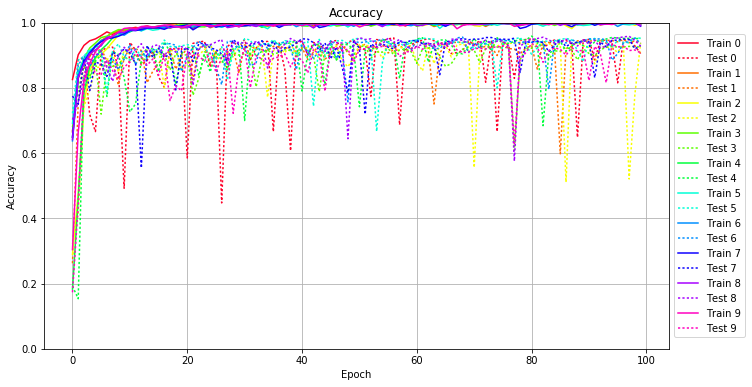

In [14]:
plot_acc(history)

In [15]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

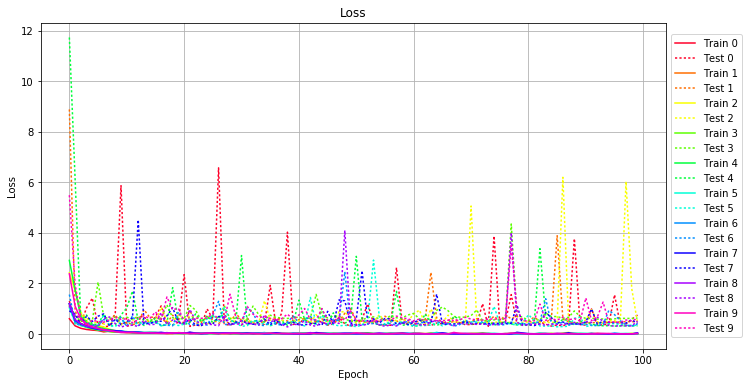

In [16]:
plot_loss(history)

Plotting the confusion matrix


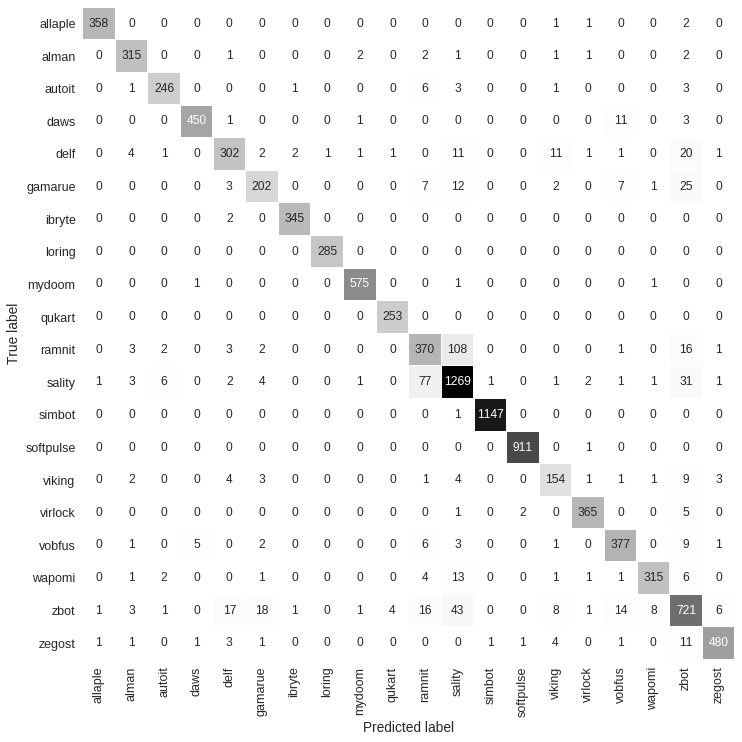

In [17]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


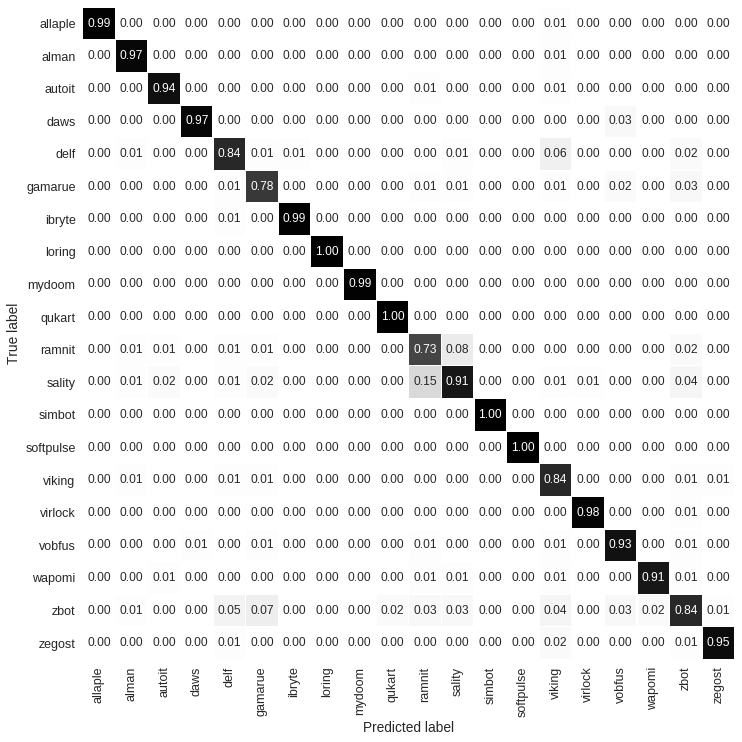

In [18]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
for h in history:
    print(h.history)

{'acc': [0.82561457418788409, 0.90144863926181673, 0.9302019315188762, 0.94435908691834947, 0.95017559262510976, 0.96016242328288792, 0.97168568930571486, 0.96411325734785713, 0.97388059711958674, 0.97783143107989468, 0.98211150131694469, 0.98551360853310732, 0.98200175592625105, 0.98430640913081646, 0.98287971905179983, 0.98222124670763833, 0.98803775241439862, 0.98694029855979337, 0.98935469710272173, 0.99165935041194841, 0.98902546093064092, 0.98266022827041266, 0.99297629499561013, 0.98847673397717295, 0.99330553116769094, 0.98825724319578578, 0.99001316944688322, 0.98957418788410889, 0.99550043898156282, 0.99154960502125489, 0.99571992976294998, 0.99209833187006147, 0.99045215100965756, 0.99308604049096516, 0.99374451273046527, 0.98979367866549606, 0.99220807726075499, 0.99495171202809485, 0.99517120280948201, 0.99703687445127309, 0.99714661984196662, 0.99462247585601404, 0.98946444259807664, 0.99374451273046527, 0.99517120280948201, 0.99495171202809485, 0.99879280070237053, 0.998

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

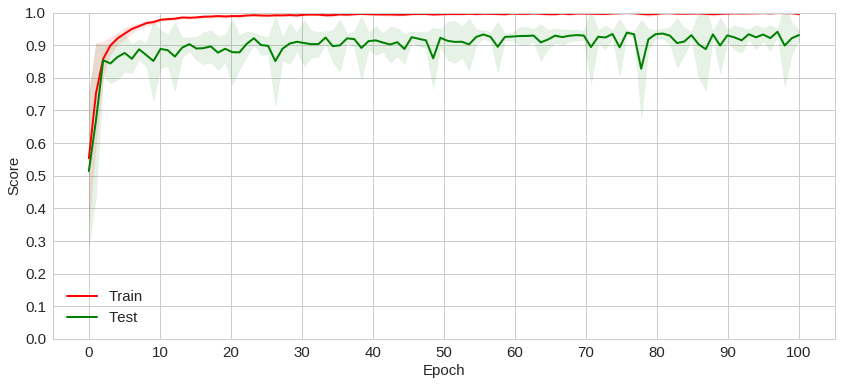

In [21]:
plot_mean_acc(history)

In [22]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

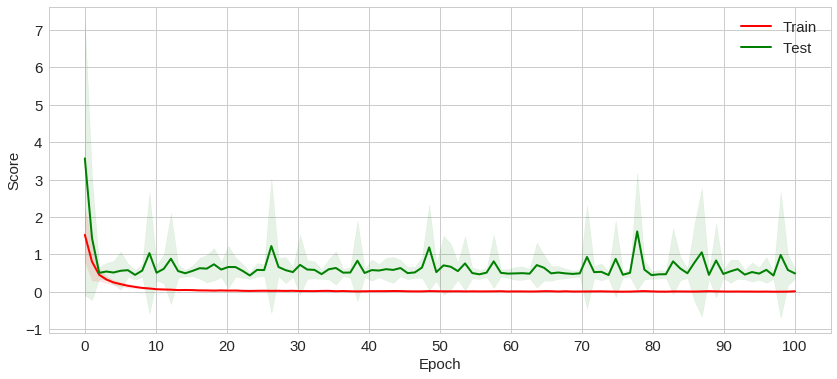

In [23]:
plot_mean_loss(history)

In [25]:
history = [{'acc': [0.82561457418788409, 0.90144863926181673, 0.9302019315188762, 0.94435908691834947, 0.95017559262510976, 0.96016242328288792, 0.97168568930571486, 0.96411325734785713, 0.97388059711958674, 0.97783143107989468, 0.98211150131694469, 0.98551360853310732, 0.98200175592625105, 0.98430640913081646, 0.98287971905179983, 0.98222124670763833, 0.98803775241439862, 0.98694029855979337, 0.98935469710272173, 0.99165935041194841, 0.98902546093064092, 0.98266022827041266, 0.99297629499561013, 0.98847673397717295, 0.99330553116769094, 0.98825724319578578, 0.99001316944688322, 0.98957418788410889, 0.99550043898156282, 0.99154960502125489, 0.99571992976294998, 0.99209833187006147, 0.99045215100965756, 0.99308604049096516, 0.99374451273046527, 0.98979367866549606, 0.99220807726075499, 0.99495171202809485, 0.99517120280948201, 0.99703687445127309, 0.99714661984196662, 0.99462247585601404, 0.98946444259807664, 0.99374451273046527, 0.99517120280948201, 0.99495171202809485, 0.99879280070237053, 0.99835381913959609, 0.99242756814680355, 0.99462247585601404, 0.99824407374890256, 0.99341527661071527, 0.99122036884917408, 0.99681738366988581, 0.99670763838385368, 0.99868305531167689, 0.9996707638279192, 0.99681738366988581, 0.98979367866549606, 0.99703687445127309, 0.99703687445127309, 0.9945127304653204, 0.99758560140474095, 0.99890254609306406, 0.99429323968393324, 0.99714661984196662, 0.99791483757682176, 0.99703687445127309, 0.99275680431888436, 0.99659789288849865, 0.99593942054433715, 0.99736611062335379, 0.99846356453028973, 0.99637840210711148, 0.99923178226514486, 0.9993415276558385, 0.99506145741878838, 0.99648814749780512, 0.99615891132572432, 0.99692712906057945, 0.99835381913959609, 0.9990122914837577, 0.99385425812115891, 0.99736611062335379, 0.99747585601404742, 0.9990122914837577, 0.99846356453028973, 0.9990122914837577, 0.99593942054433715, 0.99769534679543459, 0.99956101854188695, 0.99824407374890256, 0.99308604049096516, 0.99637840210711148, 0.99802458296751539, 0.99791483757682176, 0.99956101843722567, 0.99978050921861283, 0.99978050921861283, 0.99407374900720746], 'loss': [0.60314590434843873, 0.3227499281959747, 0.22457333567492579, 0.17775064188810399, 0.15376823139928864, 0.13544414603969865, 0.083237734055383705, 0.11269897278202036, 0.092394965468996629, 0.070455365901963357, 0.063847729562568345, 0.049238787253229464, 0.054614437935610986, 0.049106708122907933, 0.057279715465098725, 0.059830084018416614, 0.039385868775367219, 0.045841447160173701, 0.034527873820463753, 0.031953515058720225, 0.033013755418422067, 0.056894093378795731, 0.02342167940740764, 0.033589077256700677, 0.022281740709741274, 0.041038209337968451, 0.033525571787558765, 0.037046035356639535, 0.015035191470029607, 0.025494050730982203, 0.014590118857830259, 0.027656571187177559, 0.028392427625105254, 0.021310590213172661, 0.022702340736534314, 0.029342427316714669, 0.029588496809167794, 0.017239207592158096, 0.014248204751404703, 0.01343626076532841, 0.0088765448185260994, 0.016684343391602352, 0.040122043064592446, 0.020622064943204434, 0.016735840013145025, 0.015516606246714318, 0.004015685047429331, 0.0061155181329217052, 0.025636834216135888, 0.017654346490652641, 0.0053246760397632582, 0.023639403692512124, 0.033342582714889865, 0.011563005230348115, 0.010746972345461186, 0.0044799070740467982, 0.0013253142789034795, 0.011431843359073048, 0.035054112335716481, 0.0096530755617478051, 0.0090727579465143572, 0.017217545783124295, 0.011575608589056261, 0.00401144820624474, 0.020577447910678375, 0.010197497078672738, 0.0059336713926713726, 0.0091553280149944578, 0.022519371081395241, 0.013665866077230327, 0.014481387526108933, 0.0092795378443439724, 0.006705693868627495, 0.014561177568304455, 0.003415948878657731, 0.0040840991273660195, 0.017477936082702782, 0.01157645349381986, 0.017182920070801719, 0.011923668407488324, 0.0057188688600099957, 0.0047815383762916238, 0.024582232759066507, 0.0099475859384795962, 0.0080936441018182904, 0.0035043478799486188, 0.0057617525726402904, 0.0049858898229961134, 0.01484833613333292, 0.0066157331950333258, 0.0016977297778882944, 0.0072185191409185863, 0.025900387070885714, 0.0139516716698524, 0.0059735234751204956, 0.008720123730395735, 0.0020469552106519456, 0.00098500633705190903, 0.00079411568650538831, 0.021069572413112796], 'val_acc': [0.666015625, 0.8857421875, 0.89453125, 0.71875, 0.666015625, 0.9130859375, 0.923828125, 0.9248046875, 0.8583984375, 0.4921875, 0.939453125, 0.916015625, 0.8701171875, 0.8837890625, 0.9130859375, 0.833984375, 0.8017578125, 0.9208984375, 0.9189453125, 0.9228515625, 0.5849609375, 0.9365234375, 0.9404296875, 0.943359375, 0.86328125, 0.9130859375, 0.447265625, 0.9267578125, 0.94140625, 0.92578125, 0.9482421875, 0.88671875, 0.921875, 0.94140625, 0.9423828125, 0.666015625, 0.9375, 0.8564453125, 0.607421875, 0.9365234375, 0.943359375, 0.900390625, 0.939453125, 0.9296875, 0.919921875, 0.94140625, 0.9453125, 0.9130859375, 0.9404296875, 0.9462890625, 0.9248046875, 0.916015625, 0.7744140625, 0.9482421875, 0.9443359375, 0.9501953125, 0.953125, 0.6865234375, 0.916015625, 0.9326171875, 0.9404296875, 0.9462890625, 0.951171875, 0.9443359375, 0.935546875, 0.94140625, 0.9052734375, 0.908203125, 0.9140625, 0.9453125, 0.931640625, 0.9453125, 0.8173828125, 0.9453125, 0.666015625, 0.9404296875, 0.931640625, 0.8291015625, 0.9462890625, 0.9482421875, 0.9501953125, 0.943359375, 0.9208984375, 0.9365234375, 0.947265625, 0.9443359375, 0.9453125, 0.9345703125, 0.6484375, 0.947265625, 0.9482421875, 0.8857421875, 0.9453125, 0.9375, 0.9423828125, 0.8154296875, 0.9482421875, 0.9482421875, 0.9287109375, 0.9052734375], 'val_loss': [1.3013722160202406, 0.44154303663965244, 0.4265425716657143, 1.0332811029311415, 1.4177380455330422, 0.31228483461995893, 0.27862912264390616, 0.31886545009911105, 0.82760722200221881, 5.8674638379525277, 0.30980175366877605, 0.35537130281760021, 0.67594807714164151, 0.68349985035821703, 0.44443512215372927, 0.67192370547381675, 1.113705811990485, 0.39663286363352412, 0.36496163889128841, 0.46490981090096417, 2.3466294903123526, 0.30046826182101727, 0.35677573469815194, 0.32423443507391569, 0.9921873741996321, 0.59064731859143649, 6.5721852095666691, 0.40489929083415266, 0.33578444194453683, 0.50843909597409098, 0.35245438048149547, 0.62008066936687456, 0.39885371078537624, 0.39401757032256901, 0.38528097199284383, 1.9250947996974901, 0.34674399908033582, 0.82702803207519793, 4.0279414055273737, 0.37751680869216253, 0.4101786378896275, 0.61585254097761322, 0.40622684803671394, 0.4916451456324431, 0.49267595868061687, 0.35309801967384802, 0.39537636751707739, 0.66321947639708334, 0.39997406115778222, 0.30926309015112663, 0.38309838505458282, 0.58383510337239652, 1.1927677289609755, 0.42028842018817425, 0.37159033060209534, 0.35706950262048442, 0.34627716734559755, 2.6258948890625438, 0.42935773603824323, 0.39090838237781789, 0.41325556256012819, 0.36395838824261029, 0.38035208115917962, 0.33639260540752236, 0.43491860631277302, 0.3969734924730175, 0.53494317441821737, 0.624841287270959, 0.44609834405141058, 0.36809733805588651, 0.37608631907745105, 0.40121184513947661, 1.1963378026266591, 0.30786625737055262, 3.8748576443690403, 0.40922278160975045, 0.50189026612548782, 1.5578165249577633, 0.38742413671781462, 0.36251088188003022, 0.37447286720048245, 0.36915588971535174, 0.47576317792371459, 0.38823290504164687, 0.31040275623128011, 0.35491943254036729, 0.32563104883883032, 0.39978720465633, 3.7709042158441535, 0.37175298494971454, 0.34766498553024139, 0.99027281022761038, 0.34023578949679933, 0.36677038134080142, 0.38714153651132488, 1.5500530614678327, 0.36106856882646454, 0.39420505673826955, 0.58284484213285426, 0.75071312448387406]},
{'acc': [0.66469168333413964, 0.8282861533802226, 0.88150098759640927, 0.89543559359227565, 0.92912003529393572, 0.94513934615256368, 0.95676980470915174, 0.96818082089850011, 0.97465437788018439, 0.9743252140481089, 0.98123765644442229, 0.98233486943164361, 0.98474873829651799, 0.99045424621461486, 0.98266403344683617, 0.98376124652561614, 0.98782093482554312, 0.99517226245336843, 0.9962694755321484, 0.98167654158437567, 0.98617511520737322, 0.9937458855425132, 0.99374588545095455, 0.99692780337941633, 0.98430985315656461, 0.99045424630617351, 0.99242922975641867, 0.99615975422427039, 0.99429449199034448, 0.99275839377161124, 0.98869870528856707, 0.99407504937458857, 0.995611147776439, 0.99528198385280497, 0.98847926267281105, 0.99561114768488035, 0.99747640991880626, 0.99725696730305025, 0.99374588545095455, 0.99451393460610049, 0.9946236559139785, 0.99199034452490675, 0.99429449199034448, 0.99451393460610049, 0.99451393460610049, 0.99550142637700245, 0.99714724599517224, 0.99857362308914477, 0.99659863954734096, 0.9927583936800527, 0.9929778362958086, 0.99670836076366032, 0.99703752468729423, 0.99879306561334213, 0.99890278692122014, 0.99341672152732063, 0.99231950844854067, 0.99615975422427039, 0.99605003300795092, 0.99857362299758612, 0.99956111476848808, 0.99956111476848808, 0.99714724599517224, 0.98804037744129913, 0.9929778362958086, 0.99550142637700245, 0.99758613122668427, 0.99901250822909804, 0.99934167215273206, 0.99945139346061007, 0.99923195084485406, 0.99736668861092825, 0.98836954136493305, 0.99714724599517224, 0.9981347377660742, 0.99923195084485406, 0.99879306561334213, 0.99594031160851437, 0.99736668870248679, 0.99583059030063636, 0.99714724599517224, 0.99692780337941633, 0.99769585253456217, 0.99681808207153833, 0.99605003291639238, 0.99605003291639238, 0.99517226254492708, 0.99670836076366032, 0.99934167215273206, 0.99934167215273206, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99967083607636598, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398], 'loss': [1.1072127056508989, 0.56182418574307447, 0.38946319487054593, 0.35092517332024081, 0.21757509465381872, 0.16635435318996541, 0.13134030562522825, 0.098392570366363979, 0.080622740988312042, 0.074750094168298545, 0.059323030497183106, 0.054727575823048283, 0.044271468100278412, 0.028265088205878735, 0.051112216518709952, 0.051118137384810837, 0.038667360945349886, 0.016866881153312269, 0.014675315415233094, 0.053860473598191905, 0.043684938761172867, 0.017618261504426209, 0.020283624741772182, 0.010993124514639161, 0.050164585291974727, 0.02709291774908517, 0.024931766268256043, 0.014549087935795946, 0.017935224479381735, 0.020842547531651805, 0.036188090312699726, 0.02091027726194461, 0.013260053105390532, 0.016838787999651984, 0.03612444722071672, 0.012779373243857218, 0.010595985166801559, 0.0089495281710468555, 0.01614635037045082, 0.016352950951338249, 0.018899791854700702, 0.022620079887235675, 0.016205913996800412, 0.020179670940946571, 0.016606565751909406, 0.014946079030627607, 0.0084925399856487314, 0.0056220982611640564, 0.012177715491767846, 0.023231166540065542, 0.020551785080285073, 0.011297323088995894, 0.011184272592435136, 0.0046646543694143774, 0.0039391778696366052, 0.021959527090099375, 0.025218367215320763, 0.011210276328400239, 0.014247375555309754, 0.0056034008525125264, 0.0024450657178168179, 0.0016260007794791655, 0.010845036779503828, 0.033929068913358805, 0.022144540926517013, 0.014109131737312477, 0.006962481445444482, 0.0031054854056452815, 0.0026303242158731881, 0.0022016071319046005, 0.002945537313115656, 0.0097356057261306327, 0.043161193390747241, 0.0087001884498695246, 0.0060470216357902699, 0.0028084055272992819, 0.0048909329367165764, 0.014906759167875153, 0.0087684522863693444, 0.014043581920918573, 0.010275713565380328, 0.010516256737149905, 0.00770658873861852, 0.0081657032432708374, 0.012654168756216258, 0.014302454732417896, 0.017152777789892899, 0.01169697184583232, 0.0019512407176244416, 0.0016220548127927293, 0.00099711878068195849, 0.00094275951400491441, 0.0012907703717585266, 0.00088371843402221739, 0.00084923650358328722, 0.00096650983365998734, 0.00097765165550664198, 0.0010832446403177811, 0.00099214367588956178, 0.00077796113093832613], 'val_acc': [0.26223092104824086, 0.75636007921103166, 0.87377690895662852, 0.9021526428118144, 0.90900195694716246, 0.91976516727365398, 0.88258317118754825, 0.88062622309197647, 0.80821917901533691, 0.89138943248532287, 0.92172211536922566, 0.91878669369244059, 0.91487279843444225, 0.81604696766504337, 0.85127201565557731, 0.87573385518590996, 0.89236790606653615, 0.91878669275929548, 0.8571428571428571, 0.90019569471624261, 0.91976516634050876, 0.82485322896281799, 0.92367906159850721, 0.92759295499021521, 0.87573385518590996, 0.91193737862394753, 0.92074363992172215, 0.90900195694716246, 0.92074363992172215, 0.84442270245337436, 0.93150684931506844, 0.9285714285714286, 0.91878669275929548, 0.91682974559686892, 0.91389432485322897, 0.92759295499021521, 0.92563600782778865, 0.92465753424657537, 0.91682974559686892, 0.91095890410958902, 0.92367906159850721, 0.88649706457925637, 0.90998043052837574, 0.93052837573385516, 0.88747553816046965, 0.90606653620352251, 0.93248532289628183, 0.93150684931506844, 0.90704500978473579, 0.8855185919311882, 0.92661448140900193, 0.93346379647749511, 0.90900195694716246, 0.94031311154598829, 0.93444227005870839, 0.90704501071788091, 0.91682974559686892, 0.93346379647749511, 0.90998043052837574, 0.92074363992172215, 0.94227005870841485, 0.93737769080234834, 0.91976516634050876, 0.75048923679060664, 0.90704500978473579, 0.93150684931506844, 0.9393346379647749, 0.9393346379647749, 0.94031311154598829, 0.93835616438356162, 0.93639921722113506, 0.92367906066536198, 0.92661448140900193, 0.92563600782778865, 0.89921722113502933, 0.94227005870841485, 0.92074363992172215, 0.91878669275929548, 0.90410958904109584, 0.9227005870841487, 0.9285714285714286, 0.8571428571428571, 0.94129158512720157, 0.9393346379647749, 0.92074364085486726, 0.59784735952104839, 0.92074363992172215, 0.92759295499021521, 0.94422700587084152, 0.94324853228962813, 0.94324853228962813, 0.9452054794520548, 0.9452054794520548, 0.94618395303326808, 0.9452054794520548, 0.94129158512720157, 0.94814090019569475, 0.93835616438356162, 0.94422700587084152, 0.93835616438356162], 'val_loss': [8.8824454130725154, 0.92391001647465854, 0.40814510739450355, 0.34524885565963026, 0.32586215118469336, 0.31590504191383911, 0.44930639884796886, 0.55398748144279197, 0.76238457567302398, 0.40084088912330018, 0.46320960198026567, 0.3648646614003116, 0.44309950613648197, 0.9633914684264423, 0.65793919772386378, 0.67294254288815603, 0.6169713220465739, 0.4425959512593462, 0.74455955357894288, 0.50589725099610328, 0.44430296157938159, 0.94305272233490112, 0.42391225307174024, 0.455913371870179, 0.6922176739120115, 0.56066638530580604, 0.42886855664205636, 0.48480932943133587, 0.42632148165178152, 0.82395054579579408, 0.53809378377190631, 0.47537322171314045, 0.46506389032147355, 0.43646509636309688, 0.49248873088228912, 0.61415520084405339, 0.64085987276837009, 0.54271526907121159, 0.51639249775990115, 0.41917912797406398, 0.56881036390431883, 0.60527282070271438, 0.65237035144069444, 0.46932138816956731, 0.58999032467704415, 0.56086075081289433, 0.48115511465600341, 0.48970705806729081, 0.82223405376527914, 1.004378076069528, 0.53412039896371144, 0.5035999340626327, 0.45528863214884807, 0.51344255213813361, 0.49928963677513538, 0.7029778629795741, 0.57973971280492087, 0.4796498646212714, 0.61688820225390906, 0.46681087246634656, 0.47883051857851844, 0.4894911367609599, 0.56939016062400205, 2.4311727244915429, 0.63319263689515082, 0.45786584118477131, 0.43345631935135309, 0.49584779645455707, 0.43979981343367985, 0.49301097771004648, 0.46774371913799501, 0.6115531041255009, 0.53698100466477472, 0.49933120363699679, 0.70240644026405497, 0.51454365861028772, 0.74975428181188697, 0.59848632377395616, 0.7005446148031077, 0.52461343591511056, 0.52247680067295599, 0.66141844673323869, 0.50590659073842736, 0.44796479269146877, 0.61887598666249088, 3.8847463261153838, 0.58206203467466988, 0.48649658932407147, 0.42879507590119154, 0.44684107090142722, 0.44670028975523851, 0.45150285793704309, 0.44390246689329327, 0.44717883564738437, 0.44669557590540804, 0.47613707960287199, 0.46955806195462518, 0.48921126276447424, 0.48900157235800029, 0.47537140343784884]},
{'acc': [0.28938130765643333, 0.4778411585074237, 0.75142606414164714, 0.85136024574796165, 0.89074155341747197, 0.90225976315858647, 0.91992101804265436, 0.9407634927599825, 0.96182536200087754, 0.96588415977148279, 0.97652479167986772, 0.97707327775340058, 0.97795085563843787, 0.98332602018429138, 0.98738481790258881, 0.98672663448881093, 0.98935936814392278, 0.98837209312787122, 0.98837209302325579, 0.99308907415533132, 0.99078543220710835, 0.99045634055252707, 0.99012724879333036, 0.9884817902588855, 0.99572180781044317, 0.99056603773584906, 0.99330846862659061, 0.99473453268977619, 0.99221149627029404, 0.99254058797718292, 0.99319877139096091, 0.99341816586222031, 0.99265028521281262, 0.99681878016673975, 0.99539271615586189, 0.99440544098288719, 0.99363756033347961, 0.99111452396630506, 0.99550241333918388, 0.99572180781044317, 0.99835454146555502, 0.99791575252303644, 0.99583150504607287, 0.99243089074155333, 0.99210179903466433, 0.99780605528740673, 0.99659938569548046, 0.99747696358051774, 0.99188240456340504, 0.9938569548047389, 0.99407634927599819, 0.99703817463799915, 0.99901272487933301, 0.99583150504607287, 0.99648968845985086, 0.99550241333918388, 0.99517332163229488, 0.99780605528740673, 0.99890302764370342, 0.99923211935059242, 0.99583150509838059, 0.99045634050021936, 0.99495392716103559, 0.99758666081614744, 0.99868363317244402, 0.99824484422992543, 0.99637999122422116, 0.99824484422992543, 0.999670908293111, 0.999670908293111, 0.99089512944273805, 0.98881088196577449, 0.99802544975866603, 0.99945151382185171, 0.99934181658622201, 0.99934181658622201, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.999670908293111, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99034664331689748, 0.9818999561211057, 0.99758666081614744, 0.99890302764370342, 0.99769635805177714, 0.9941860465116279, 0.99802544975866603, 0.99758666081614744, 0.99901272487933301, 0.99934181658622201, 0.9995612110574813, 0.99857393593681443, 0.99166301009214564, 0.99780605528740673], 'loss': [2.4207131876240386, 1.7186061701998474, 0.80276857613994135, 0.49451397620255927, 0.37602575401194843, 0.32366130517051112, 0.27921323573029633, 0.19030015754132168, 0.12785153107953837, 0.10519921285651555, 0.072389415880079175, 0.068265267886456787, 0.067965719992717458, 0.050065434541505853, 0.040378600087923218, 0.040310034622773758, 0.030499397618922897, 0.035715124276215343, 0.033270867173388327, 0.022172115316934075, 0.033168166952921602, 0.032418757970491853, 0.028091801588205737, 0.03227181514290281, 0.013948306754744722, 0.029590716817836756, 0.020275677213389728, 0.017661253900629149, 0.025609871230113511, 0.026026633181930006, 0.022742191280151286, 0.024652060482164902, 0.021272872752596237, 0.01105440575835843, 0.01624683608668798, 0.015184883226683125, 0.019786549561629223, 0.026470751395299526, 0.013573971203446972, 0.012186502452260157, 0.006465669357410656, 0.0068929630658589583, 0.014611440129783359, 0.025990399469737066, 0.022219332735780167, 0.0070074737267563853, 0.0094033344332390811, 0.0071279303446197375, 0.024764251947288429, 0.017331923108556916, 0.016783543679951177, 0.0096734697862601617, 0.002790185402683013, 0.013532295039895784, 0.010743805940466202, 0.014892406696459566, 0.0166151995437312, 0.0069255117880742609, 0.0049074182849591147, 0.0032066461175140467, 0.015414598841554049, 0.029567879745549759, 0.015773082309921874, 0.0084272137134303472, 0.0058291078194922259, 0.005542599811655358, 0.0097281850499279562, 0.0066465961813418229, 0.0014952481321805586, 0.0017301191899806063, 0.029391753856879824, 0.034994097166246609, 0.0060342907545059546, 0.0022245557358095565, 0.0016340607736171353, 0.001868521035161307, 0.00097005146421605523, 0.0011426817053249482, 0.0010591725980348325, 0.0010212186457485531, 0.00086986981540306603, 0.00082645285764370354, 0.00080730685096876869, 0.00087926318055982276, 0.00091744927423653927, 0.00084673415258155289, 0.035002868670951717, 0.062568376628565958, 0.0081026114607628645, 0.003491056065158797, 0.0076972985218462754, 0.018267655030505314, 0.0072033599215249235, 0.0073912128108479481, 0.0029577663716640248, 0.0033351077967766281, 0.0017541860042643758, 0.0037064507884888502, 0.030347846172398017, 0.0071445314056943444], 'val_acc': [0.3215686275386343, 0.41568627591226615, 0.74313725630442307, 0.79313725583693562, 0.86274509944167788, 0.86372549159854062, 0.88529411858203366, 0.90686274603301409, 0.84803921662124937, 0.91568627544477876, 0.90294117740556301, 0.87352941269968065, 0.90882353034673957, 0.91568627544477876, 0.90784313818987683, 0.92058823622909247, 0.80000000093497481, 0.91372549113105328, 0.91470588328791602, 0.85392156909493844, 0.87549019701340625, 0.8813725499545827, 0.90000000093497479, 0.91764705975850425, 0.93137254995458263, 0.90098039309183753, 0.87549019748089363, 0.91078431466046506, 0.89509804015066108, 0.92450980438905606, 0.92156862838595521, 0.89901960924559954, 0.92745098132713166, 0.92647058917026892, 0.77156862838595519, 0.91372549066356579, 0.92647058917026892, 0.90686274603301409, 0.9352941185820336, 0.90294117693807563, 0.92745098132713166, 0.92156862838595521, 0.91862745191536699, 0.89117647152321011, 0.91372549113105328, 0.9235294126996807, 0.92745098132713166, 0.88235294211144544, 0.86470588328791598, 0.8931372558369356, 0.93235294211144537, 0.93137254995458263, 0.92647058917026892, 0.91960784407222973, 0.89117647058823535, 0.93039215779771989, 0.90882353034673957, 0.92058823622909247, 0.93039215779771989, 0.92941176564085715, 0.87941176610834459, 0.85196078524870034, 0.93431372642517085, 0.87450980485654339, 0.93137254995458263, 0.93137254995458263, 0.89509804015066108, 0.93137254995458263, 0.93431372642517085, 0.9254901965459188, 0.55588235434363875, 0.91960784407222973, 0.93235294211144537, 0.93627451073889634, 0.9284313734839944, 0.9352941185820336, 0.93627451073889634, 0.93725490289575908, 0.94019607936634741, 0.9352941185820336, 0.93235294211144537, 0.93431372642517085, 0.93333333426830811, 0.93431372642517085, 0.9352941185820336, 0.93333333426830811, 0.51078431466046503, 0.93333333426830811, 0.93725490289575908, 0.92941176564085715, 0.9235294126996807, 0.87352941269968065, 0.92647058917026892, 0.92647058917026892, 0.91960784407222973, 0.90980392250360231, 0.93137254995458263, 0.52058823646283614, 0.78039215779771987, 0.93823529505262193], 'val_loss': [2.3650148239790232, 1.8355974754299049, 0.84906015910354404, 0.62766522775385891, 0.46176626266128107, 0.45537912188915114, 0.3891600733746457, 0.35770775958046536, 0.58588714303554945, 0.36435517667363027, 0.41371067365247405, 0.5745860222093232, 0.37889621869901163, 0.4817660340838783, 0.53111714524554965, 0.4272703921170129, 1.0630033557915157, 0.5202813830927443, 0.49391193375630005, 0.76764914384225891, 0.62568404659796573, 0.70653645135920684, 0.64933209006730219, 0.47537081413334753, 0.41077048710232134, 0.44148917350661504, 0.58560779789692885, 0.48284453157017176, 0.66420788557577537, 0.43881550721255946, 0.46122553540327166, 0.58439488593436428, 0.42734852695611708, 0.4375533193259406, 1.3164859447867385, 0.54367684310123232, 0.51495733536646326, 0.55580882448384195, 0.42550679147229903, 0.55600331286476401, 0.51492311843263294, 0.55008569445865529, 0.46315944166537437, 0.76492118227283223, 0.52725478810504733, 0.48405371342244541, 0.45251531555470637, 0.88201711757140888, 0.87274498014480473, 0.58629304873276278, 0.43360847337247005, 0.42170211484503006, 0.49069771638973775, 0.47038400041125772, 0.76818336370223039, 0.48883538299119028, 0.57854798930550033, 0.52877471887644667, 0.57339162677708955, 0.50913821884987598, 0.78971296579944716, 0.94448764770000515, 0.38941603537698172, 0.9895712410444828, 0.52941854030968227, 0.46184389319364616, 0.74612694879241792, 0.47538797214618428, 0.46026863891866548, 0.46550333956707912, 5.0636625400360913, 0.46108178426945601, 0.44188563032520478, 0.45142908423530903, 0.45176836664552411, 0.49272808946818358, 0.45174333732044908, 0.46521800075465719, 0.43885997644455949, 0.45941097369070577, 0.47671699028901549, 0.45585926764149598, 0.46167160474766855, 0.45424528649520618, 0.45859563082152122, 0.47132338647961081, 6.1976265172658414, 0.41889778210104794, 0.40746664195355475, 0.44082174835389865, 0.55924506584810751, 0.96292450849775657, 0.47514965551505051, 0.45219715697502777, 0.52438876904660559, 0.52335990002809196, 0.45639024884271479, 6.0307825967005382, 1.7867123293907667, 0.44993461669817086]},
{'acc': [0.6479166666666667, 0.84835526315789478, 0.89002192982456141, 0.92214912280701755, 0.93739035087719302, 0.95427631578947369, 0.95855263157894732, 0.97017543859649125, 0.97861842105263153, 0.97850877192982455, 0.98081140350877194, 0.97949561403508767, 0.98366228070175443, 0.98344298245614037, 0.98585526315789473, 0.98936403508771931, 0.99024122807017545, 0.98278508771929829, 0.99111842105263159, 0.99418859649122804, 0.99353070175438596, 0.99024122807017545, 0.98717105263157889, 0.98717105263157889, 0.9916666666666667, 0.99418859649122804, 0.9944078947368421, 0.99265350877192982, 0.99046052631578951, 0.99111842105263159, 0.99298245614035086, 0.99671052631578949, 0.99616228070175439, 0.98541666666666672, 0.99035087719298243, 0.99484649122807023, 0.99462719298245617, 0.99638157894736845, 0.99682017543859647, 0.99835526315789469, 0.99035087719298243, 0.98936403508771931, 0.99638157894736845, 0.99649122807017543, 0.99769736842105261, 0.9978070175438597, 0.98958333333333337, 0.99177631578947367, 0.99429824561403513, 0.99857456140350875, 0.99956140350877198, 0.99934210526315792, 0.98914473684210524, 0.99429824561403513, 0.99473684210526314, 0.99682017543859647, 0.99703947368421053, 0.99813596491228074, 0.99879385964912282, 0.99868421052631584, 0.9888157894736842, 0.99407894736842106, 0.99714912280701751, 0.99802631578947365, 0.99747807017543855, 0.99418859649122804, 0.99396929824561409, 0.99375000000000002, 0.99747807017543855, 0.99879385964912282, 0.99912280701754386, 0.99594298245614032, 0.99144736842105263, 0.99835526315789469, 0.99956140350877198, 0.99967105263157896, 0.99956140350877198, 0.9944078947368421, 0.99046052631578951, 0.99638157894736845, 0.99934210526315792, 0.99956140350877198, 0.99978070175438594, 0.99824561403508771, 0.99144736842105263, 0.99769736842105261, 0.99890350877192979, 0.9978070175438597, 0.99364035087719293, 0.99550438596491231, 0.99605263157894741, 0.99539473684210522, 0.99846491228070178, 0.99934210526315792, 0.99956140350877198, 0.99923245614035083, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99934210526315792], 'loss': [1.1816854246875697, 0.48774169761883585, 0.34349170549396885, 0.25704248534482821, 0.19624427653391632, 0.14764247677174577, 0.13112267079321963, 0.094302416940039976, 0.069271430758792052, 0.065793036907633537, 0.061697765775106585, 0.066603000632797685, 0.051398273505548243, 0.058126911758281816, 0.044628609458940399, 0.034906403040983143, 0.029494878427194955, 0.055144664505598739, 0.029036807497246436, 0.019923884126846883, 0.020147810028107702, 0.031681865063167114, 0.03799754387151201, 0.037613739612667514, 0.025853147584827017, 0.019085470469450996, 0.020141417185840782, 0.0240154299591188, 0.02815171718052864, 0.028950144499047606, 0.023328094070466092, 0.011227140283785717, 0.013775256612659673, 0.043005643390119586, 0.033947222019336899, 0.015774424967626224, 0.019295294889289244, 0.011413367561145972, 0.0091468161713763908, 0.0058836143125358432, 0.030107202992736636, 0.038979779340361509, 0.010436237414736146, 0.011248342391809274, 0.0079994182860805025, 0.0075702721625738809, 0.033089127737191137, 0.026113857614326295, 0.01886087927695802, 0.0037709987742090834, 0.002247665978554499, 0.0021892767898399352, 0.032103324633968248, 0.020431303817014468, 0.018149105775793081, 0.011151867912900472, 0.009611442085649782, 0.0059992212636037342, 0.0047911509816346729, 0.0043710573146343353, 0.039525863697234168, 0.017458342093206673, 0.0097561678946779772, 0.0078043295398473626, 0.0097683138627865825, 0.018998392544885414, 0.016135031174150771, 0.022041286690228732, 0.0073897900287871032, 0.003875831643462366, 0.0025964499837131004, 0.012806583235988399, 0.030590274460120238, 0.0049231334752731894, 0.0015304625687118109, 0.0018342594743879154, 0.001272118536001655, 0.022367664541357562, 0.033568163889082681, 0.0097154498967172813, 0.002292013247714701, 0.001634926358156407, 0.0012389554967913491, 0.0059607224609815029, 0.024595932613890495, 0.0058042746408769391, 0.0042062669977982739, 0.0067192310732535959, 0.01945584129614138, 0.01354413676769837, 0.012784427052776281, 0.016051850718379189, 0.0051798389598975278, 0.002734697499804178, 0.002430345607807108, 0.0017586242772608784, 0.00084508175448103941, 0.00086899891998016979, 0.00081669587269404646, 0.0014142492346728001], 'val_acc': [0.68011811117487631, 0.7942913385826772, 0.86614173228346458, 0.83366141732283461, 0.88582677165354329, 0.71948818991503383, 0.87303149606299213, 0.86614173228346458, 0.87106299212598426, 0.89468503937007871, 0.88484251968503935, 0.90157480314960625, 0.87696850487566369, 0.89468503937007871, 0.89960629921259838, 0.90354330708661412, 0.90354330802526994, 0.85433070866141736, 0.90551181102362199, 0.89960629921259838, 0.90157480314960625, 0.77755905511811019, 0.82874015748031493, 0.91043307086614178, 0.90551181102362199, 0.8917322834645669, 0.90551181102362199, 0.86220472440944884, 0.90748031496062997, 0.90059055118110232, 0.90452755952444597, 0.90846456692913391, 0.80314960629921262, 0.89271653543307083, 0.91633858267716539, 0.90354330708661412, 0.90846456692913391, 0.91732283464566933, 0.91437007874015752, 0.89763779527559051, 0.91830708661417326, 0.91830708661417326, 0.89960629921259838, 0.78838582677165359, 0.90551181102362199, 0.90748031496062997, 0.88582677165354329, 0.90452755905511806, 0.91633858267716539, 0.93110236220472442, 0.92618110236220474, 0.92913385826771655, 0.89074803149606296, 0.91043307086614178, 0.90944881889763785, 0.92027559055118113, 0.90157480314960625, 0.91633858267716539, 0.9192913385826772, 0.91141732283464572, 0.875, 0.92027559055118113, 0.922244094488189, 0.92519685039370081, 0.89468503937007871, 0.86614173228346458, 0.87401574803149606, 0.90059055165043023, 0.9192913385826772, 0.91830708661417326, 0.91535433070866146, 0.87696850393700787, 0.92125984298901298, 0.92618110283153265, 0.92519685039370081, 0.92224409495751691, 0.92519685086302872, 0.60826771700476101, 0.88681102362204722, 0.92125984251968507, 0.92125984251968507, 0.92913385873704446, 0.93110236267405233, 0.88681102409137513, 0.91338582677165359, 0.91240157480314965, 0.92519685039370081, 0.91633858267716539, 0.88582677165354329, 0.92027559055118113, 0.90551181102362199, 0.89960629968192629, 0.9163385831464933, 0.92519685086302872, 0.92618110283153265, 0.92519685086302872, 0.92519685086302872, 0.92716535480003659, 0.92618110283153265, 0.92519685086302872], 'val_loss': [1.2189401760703107, 0.71778755673167471, 0.49430899855521038, 0.53010185864088533, 0.51171164660116064, 2.0513615663508027, 0.66187199191149626, 0.6069219697828957, 0.67434480947632236, 0.60496477577395458, 0.66287255187544214, 0.59039017469067623, 0.69821861957367415, 0.53917939370388723, 0.58953388677961927, 0.51657954636637327, 0.62284219170087307, 1.1568493074125692, 0.64312839035380254, 0.59500307334539504, 0.60664020635153826, 1.1291606222032102, 0.94343681269079582, 0.52138695488494124, 0.61030333655983937, 0.71794794792640904, 0.61270991828391375, 1.1158532112088728, 0.59620733284170735, 0.62462427155052802, 0.60955009955797712, 0.58760092987009904, 1.1033913369839659, 0.7637797369637529, 0.56654307377592394, 0.74423461964780757, 0.65930330335249876, 0.62938530197367093, 0.61485348119521754, 0.63909184069201308, 0.66863243182559373, 0.58943923992149883, 0.63346222938770635, 1.5665688596997993, 0.73625531698413549, 0.63817955865596998, 0.7282438159177469, 0.70628387489041178, 0.59437811922355299, 0.5099109635278144, 0.49304155621411289, 0.55601894487176784, 0.65283636916105903, 0.67627279793983164, 0.608045985012301, 0.54609059731853637, 0.74355229831672531, 0.64116190684943974, 0.637751913184749, 0.75306948266510099, 0.81486246814057273, 0.5945536516347838, 0.55931191591755991, 0.600193010312564, 0.93283249996615292, 1.0663955532776701, 0.91820835090187691, 0.69246499686801588, 0.66471601452706197, 0.66506884827196167, 0.72763268833366157, 0.95043502657085144, 0.5229047644555247, 0.5377121803569892, 0.55848861233245473, 0.58023511947392781, 0.59633164018728135, 4.3514760080724972, 0.73167144149404273, 0.66582499268353135, 0.53429002677468562, 0.55593274662760273, 0.55406111710342254, 0.8364064098916193, 0.68941499450659638, 0.69256971934334788, 0.61785719880305212, 0.66162121655900918, 0.91257969376275727, 0.69435468239761422, 0.61344362415208054, 0.62279592191988187, 0.58697265450541192, 0.59534288446752726, 0.57168903672977545, 0.60043770342966041, 0.62120644413012738, 0.61661658638108896, 0.61712302330647972, 0.62945930096777547]},
{'acc': [0.18311403508771928, 0.45986842105263159, 0.78585526315789478, 0.86524122807017545, 0.89276315789473681, 0.91688596491228069, 0.93322368421052626, 0.95339912280701755, 0.96162280701754388, 0.96710526315789469, 0.97171052631578947, 0.98026315789473684, 0.98399122807017547, 0.98585526315789473, 0.98497807017543859, 0.98552631578947369, 0.98289473684210527, 0.99057017543859649, 0.98914473684210524, 0.98848684210526316, 0.99254385964912284, 0.99122807017543857, 0.99353070175438596, 0.99418859649122804, 0.98706140350877192, 0.99418859649122804, 0.99429824561403513, 0.99067982456140347, 0.99243421052631575, 0.99561403508771928, 0.99418859649122804, 0.99100877192982462, 0.99638157894736845, 0.98695175438596494, 0.99451754385964908, 0.99561403508771928, 0.99758771929824563, 0.99703947368421053, 0.99594298245614032, 0.99627192982456136, 0.99144736842105263, 0.99177631578947367, 0.99539473684210522, 0.99528508771929824, 0.99243421052631575, 0.99418859649122804, 0.99649122807017543, 0.99692982456140355, 0.99846491228070178, 0.99736842105263157, 0.99638157894736845, 0.99177631578947367, 0.99517543859649127, 0.99703947368421053, 0.99791666666666667, 0.99923245614035083, 0.99407894736842106, 0.99309210526315794, 0.993859649122807, 0.99879385964912282, 0.99934210526315792, 0.99912280701754386, 0.99824561403508771, 0.99067982456140347, 0.99714912280701751, 0.99824561403508771, 0.9966008771929824, 0.99473684210526314, 0.99692982456140355, 0.99671052631578949, 0.99868421052631584, 0.99813596491228074, 0.99890350877192979, 0.99265350877192982, 0.99725877192982459, 0.99890350877192979, 0.99572368421052626, 0.9933114035087719, 0.99890350877192979, 0.99868421052631584, 0.99879385964912282, 0.9994517543859649, 0.99539473684210522, 0.99396929824561409, 0.99682017543859647, 0.99835526315789469, 0.99802631578947365, 0.99638157894736845, 0.99692982456140355, 0.99528508771929824, 0.99736842105263157, 0.99868421052631584, 0.99967105263157896, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594], 'loss': [2.9107196841323586, 1.7446961038991025, 0.68675079256819005, 0.44184885649827488, 0.34395524079078121, 0.2652432449815566, 0.21350593840082485, 0.160729992291645, 0.12935415784125789, 0.10151298367336654, 0.09494760011755779, 0.059277093864715934, 0.050612938692874948, 0.046681610799165801, 0.048387329477669772, 0.047469195435558886, 0.051710260331859451, 0.026516885556926002, 0.033697684506656958, 0.034347570871422678, 0.023754788180833618, 0.029908656741488876, 0.02217028547140153, 0.018644162533746567, 0.035982649360187025, 0.017304136172772318, 0.018704312939856513, 0.031812378174263835, 0.024746995992385914, 0.01475047654701548, 0.017163941127466643, 0.027608368860653668, 0.010980493678359555, 0.041385130495230744, 0.019728646280444146, 0.011671561918388251, 0.0085715721647399105, 0.0098649362600617841, 0.011552622630513629, 0.014570313442267465, 0.027805906668544867, 0.022095636402722, 0.014225403755227219, 0.012491913989856185, 0.020930648546945711, 0.019091890513549228, 0.011125083569690455, 0.0081130300496321684, 0.00421240283994529, 0.0089545257462672005, 0.010539951498952959, 0.026961599797403066, 0.016837453398320098, 0.010258503940320608, 0.0065752303864037619, 0.0031819332206627572, 0.017746086730573409, 0.023843071304509068, 0.019128088209056347, 0.0043666691575325739, 0.0027090537224857894, 0.0033865109344516672, 0.0053955871429998458, 0.027537233567831242, 0.011488690833531316, 0.0044682788920996693, 0.009416860079019037, 0.01737213006676859, 0.011680961181738033, 0.0089075927130061079, 0.0049685434481361564, 0.0072157946803711459, 0.0037180486243267039, 0.024613882267895428, 0.0088513414540533335, 0.0038876920003786566, 0.013988960781930553, 0.019166421085141369, 0.0053417265378404985, 0.0030651036487717265, 0.0030600622386331403, 0.001565723168755041, 0.016005942818547905, 0.017028973925277427, 0.0089796524247990495, 0.0052705359719184023, 0.0056772032579617687, 0.010491494145512741, 0.0099347381683580691, 0.013845357884237306, 0.0078437535862413074, 0.0040616000782237229, 0.0019612816037948232, 0.0012038971500178456, 0.00095466554591595062, 0.00087857486173920497, 0.00085387458986783634, 0.00078564635881169431, 0.0007909238017456226, 0.00063674612634307532], 'val_acc': [0.19192913432759562, 0.15354330755594209, 0.83956692913385822, 0.8248031500756271, 0.88385826818586333, 0.89960629968192629, 0.77362204771342236, 0.91141732330397363, 0.9025590555874381, 0.83070866188665071, 0.72637795322523346, 0.75098425243783185, 0.888779528028383, 0.92519685086302872, 0.91830708708350117, 0.84940944928822559, 0.94192913432759562, 0.90944881936696575, 0.81102362298589992, 0.90551181149295001, 0.92519685086302872, 0.91929133905200511, 0.83759842566617826, 0.9025590555874381, 0.84842519778904957, 0.91043307133546969, 0.88484252015436726, 0.8553149610992492, 0.92125984298901298, 0.9301181107055484, 0.69980315054495501, 0.92913385873704446, 0.89665354377641449, 0.91240157527247756, 0.9133858272409815, 0.94291338629609955, 0.93208661464255627, 0.93503937054806807, 0.93799212645357988, 0.94389763826460349, 0.79035433117798937, 0.90551181149295001, 0.93208661511188418, 0.9330708666110602, 0.81003937007874016, 0.93700787448507594, 0.8858267721228712, 0.93405511857956414, 0.93208661464255627, 0.91929133905200511, 0.74212598472129643, 0.9163385831464933, 0.92224409495751691, 0.91830708708350117, 0.9498031500756271, 0.94192913432759562, 0.93503937054806807, 0.82874015794964284, 0.93996063039058775, 0.93700787448507594, 0.9498031500756271, 0.95374015794964284, 0.87893700834334365, 0.93602362251657201, 0.94685039417011529, 0.94685039417011529, 0.93208661464255627, 0.90551181196227792, 0.90452755952444597, 0.92913385873704446, 0.95078740204413104, 0.92814960676854052, 0.94783464613861923, 0.91240157527247756, 0.95374015841897075, 0.93405511857956414, 0.93700787448507594, 0.94192913432759562, 0.9498031500756271, 0.94685039417011529, 0.95866141779216252, 0.94389763826460349, 0.68405511857956414, 0.90748031496062997, 0.91437007920948543, 0.94291338629609955, 0.91240157527247756, 0.92814960676854052, 0.94291338629609955, 0.92913385873704446, 0.92421259889452478, 0.94094488235909168, 0.94586614220161136, 0.9498031500756271, 0.95472440991814678, 0.95275590598113891, 0.95177165401263497, 0.95177165401263497, 0.95078740204413104, 0.95177165401263497], 'val_loss': [11.729078447783557, 6.1446120100697197, 0.54185846768407608, 0.75027470308260658, 0.38846606377951753, 0.37305147409419381, 0.80098095516257484, 0.3179999978288891, 0.34667041651193259, 0.74969058786112464, 1.0291030700208517, 1.6988762178501586, 0.52165647824276529, 0.33714180049627623, 0.48419950471114448, 0.61490234893959339, 0.29909562278745994, 0.41718283204597434, 1.8336328744505488, 0.50220956686086371, 0.35887772315200217, 0.46721209390762658, 0.79309056081999763, 0.47875995366602303, 0.71909291880442683, 0.44918265018638098, 0.68422694876159851, 0.75583757828429754, 0.5805749594328804, 0.4343752818462478, 3.1031987655738118, 0.37348081680182249, 0.52963521262008872, 0.50321153763147808, 0.47349425889914293, 0.31783796767139011, 0.45172350955338991, 0.51013377602527854, 0.34538511633038044, 0.40734608315253396, 1.3387380290783824, 0.56153785548649038, 0.4435052646788622, 0.4059147281904274, 1.0021063976062463, 0.36551815335388221, 0.83627302123131797, 0.47901205130080005, 0.43277453402965815, 0.52691305826252699, 3.071002328864965, 0.55702051068197811, 0.41072906594451064, 0.50209959389297099, 0.35024544815826308, 0.37300509454450465, 0.44838095435876568, 1.6848474543775298, 0.34040870694689435, 0.39145414329205658, 0.30839791600786381, 0.32819313236818359, 0.79712417503561295, 0.41361098328612894, 0.34028824865783497, 0.42754799713565994, 0.39842904356358011, 0.68637481567336045, 0.59635612739279398, 0.44677520546185662, 0.38433252686003044, 0.46627565241425506, 0.39507478882171831, 0.51840331550721297, 0.3408018660978791, 0.44262831904377686, 0.47566115676541648, 0.3985932956640581, 0.35915302648291214, 0.3719030283067804, 0.3529090321170395, 0.44505162771533618, 3.3748293365620694, 0.65683648724252575, 0.53698792444219912, 0.39878553481912427, 0.57946823496704558, 0.52683000996212093, 0.36745360657232595, 0.5007223041474852, 0.4432576762598977, 0.39166864956002151, 0.34020049338634839, 0.3248609631676142, 0.32950685725115531, 0.31240711809060684, 0.31716041217568786, 0.31864127415287824, 0.32382038591462903, 0.32073295820044306]},
{'acc': [0.69106849316374896, 0.8488767123320331, 0.88800000000653201, 0.91441095891064161, 0.92536986301696467, 0.92887671232876712, 0.95484931506849313, 0.95791780823224215, 0.96010958904762789, 0.96701369863666897, 0.97643835616438357, 0.98005479452708, 0.97468493150684932, 0.98147945206785858, 0.97676712329420323, 0.97928767123287674, 0.9915616438421484, 0.98564383561643831, 0.98827397260927174, 0.98432876712981965, 0.98619178082191783, 0.99342465754077858, 0.98871232876712334, 0.99189041095890407, 0.99419178082191784, 0.99200000000653199, 0.98586301369863016, 0.99243835616438358, 0.99178082191780825, 0.98958904109589041, 0.99638356164383557, 0.99846575342465749, 0.99287671232876717, 0.98947945206785859, 0.98136986301369866, 0.99627397260273975, 0.9960547945205479, 0.99649315068493149, 0.99704109589041101, 0.9935342465818745, 0.99123287671886073, 0.99232876712328766, 0.99594520547945209, 0.99747945206132649, 0.99145205480105258, 0.98980821918461426, 0.99506849315068491, 0.99671232878018734, 0.98663013698630142, 0.99715068493150683, 0.99956164383561641, 0.99912328767776493, 0.99539726027397257, 0.99649315068493149, 0.99265753425310732, 0.99123287671232874, 0.99726027397260275, 0.99419178082191784, 0.99627397260273975, 0.99660273972602742, 0.99967123287671233, 0.99978082191780826, 0.99978082191780826, 0.99967123288324433, 0.9825753424657534, 0.99616438356164383, 0.99736986302023067, 0.99649315068493149, 0.99835616439009367, 0.9945205479452055, 0.99758904110895441, 0.9945205479452055, 0.99857534246575341, 0.99726027397260275, 0.99178082191780825, 0.99693150684931509, 0.99846575342465749, 0.999013698630137, 0.99978082191780826, 0.99846575342465749, 0.99693150684931509, 0.99561643835616442, 0.989041095890411, 0.99616438356164383, 0.99835616438356167, 0.99945205479452059, 0.99956164383561641, 0.99967123287671233, 0.99364383561643832, 0.99123287671886073, 0.99276712329420325, 0.99660273972602742, 0.99791780821917808, 0.99835616438356167, 0.99923287671232874, 0.99704109589694301, 0.99495890412265309, 0.99309589041749091, 0.99572602741032434, 0.99386301369863017], 'loss': [1.0319790677893652, 0.49592726275039045, 0.3564865400268607, 0.27738963797974259, 0.23410416763122768, 0.2223367965564336, 0.1491294902722313, 0.13165570979004038, 0.1228938887045808, 0.1035398543330088, 0.073853286061793158, 0.06233811827534682, 0.076820448907270827, 0.058343457473977789, 0.069337689065769925, 0.065854614625850766, 0.030277263340374377, 0.045415547609227162, 0.037196444277154052, 0.051771752628816725, 0.046983008896306869, 0.02159866621952555, 0.035718111563984252, 0.028665799137536589, 0.017031050974171454, 0.022727006856084177, 0.04306252575650403, 0.023192089928090829, 0.024527069631989484, 0.035443603013833501, 0.014001820406736169, 0.0053043270832029716, 0.025320323998765534, 0.031203039790644017, 0.059679881752149701, 0.011424342562202108, 0.011585454722895121, 0.012279044305714332, 0.010190008635441327, 0.018887887413986663, 0.030244391755877089, 0.02678536954893386, 0.014595310954415328, 0.0077830315180559811, 0.029149427451512278, 0.031376609735267416, 0.015317454208320881, 0.010671438837194279, 0.045321399617557455, 0.0094881380769322073, 0.0020506538215216111, 0.0025806196527882507, 0.014840830424564496, 0.011741126988309576, 0.023479046153089617, 0.030192509383026971, 0.011103277953131098, 0.019671966915352154, 0.011119592403694796, 0.011456731267597156, 0.0017568722471362776, 0.0010996621343985357, 0.00088576922667402559, 0.0016835051139581219, 0.06606131299534751, 0.011334015175339779, 0.0084415652306243285, 0.012290646957321258, 0.0045796720921269249, 0.016864955842660817, 0.0069808218600706847, 0.018587941154182174, 0.0047182456748051747, 0.010359274694029271, 0.028283483880943594, 0.010465245042508946, 0.0041370486715690503, 0.002994697964466767, 0.001320482029256647, 0.0043171635273780611, 0.010154751007921981, 0.012049284105085887, 0.036275114914086609, 0.012002684103286736, 0.0046149472428471004, 0.0027724021758082041, 0.0013547242741935332, 0.0013186914908643577, 0.018371075585380051, 0.028036793681678093, 0.024646428487681438, 0.011320659067003337, 0.0049140538443565645, 0.004909192053507057, 0.0030790540256130042, 0.010052348231237736, 0.015647299454203401, 0.023642826644464536, 0.01402276389839842, 0.01752779768682635], 'val_acc': [0.72205736976702772, 0.88526211754150841, 0.89713155333059591, 0.91988130605067508, 0.9099901092158581, 0.91493570763326659, 0.78832838856030174, 0.91394658794978489, 0.93471810130290056, 0.89614243364711421, 0.88526211712881553, 0.91988130563798221, 0.89614243364711421, 0.89910979269755931, 0.91394658794978489, 0.91889218636719339, 0.94658753750468105, 0.92680514383504697, 0.92581602415156528, 0.92878338278931749, 0.93273986193593716, 0.92779426310583579, 0.91790306668371169, 0.93372898120672598, 0.88625123681229723, 0.88427299703264095, 0.92581602456425816, 0.82393669675295012, 0.91493570763326659, 0.92680514342235409, 0.95054401623860785, 0.94658753709198817, 0.9129574682663032, 0.93669634066986396, 0.93372898161941886, 0.94757665718816275, 0.93273986152324428, 0.94460929772502478, 0.94263105835806138, 0.900098912793734, 0.93570722057368938, 0.94263105877075426, 0.74381800239093221, 0.94856577645895157, 0.89515331355093963, 0.93372898120672598, 0.94362017845423596, 0.94559841782119936, 0.93471810130290056, 0.95054401582591497, 0.95153313550939667, 0.94757665677546987, 0.92977250288549207, 0.66666666648979833, 0.87734915966096194, 0.93867458044952035, 0.92284866510112018, 0.93867458003682747, 0.9248269040553907, 0.94362017804154308, 0.94658753709198817, 0.95252225519287836, 0.95054401582591497, 0.94955489614243327, 0.92581602415156528, 0.94263105835806138, 0.94065281899109787, 0.94065281899109787, 0.93768546035334566, 0.94164193908727256, 0.91790306627101881, 0.93768546035334566, 0.93372898161941886, 0.94164193908727256, 0.80019782393669636, 0.94362017845423596, 0.94559841740850648, 0.94955489655512615, 0.95450049497253464, 0.93076162256897377, 0.90306627143148621, 0.9228486646884273, 0.94460929813771766, 0.94164193867457957, 0.94460929772502478, 0.94856577645895157, 0.95153313550939667, 0.94757665718816275, 0.91394658794978489, 0.88031651871140704, 0.94757665718816275, 0.95153313592208955, 0.94263105877075426, 0.94164193908727256, 0.92482690446808358, 0.94559841740850648, 0.93867457962413448, 0.93867457962413448, 0.95252225519287836, 0.95252225519287836], 'val_loss': [1.1182160669160246, 0.38835282828640394, 0.34899450563406526, 0.26712434945520269, 0.33178190038651112, 0.28535909311301016, 0.76553506870467569, 0.3350517973834356, 0.29400176743862172, 0.48759270375028435, 0.50648240192361949, 0.41261117183626511, 0.41339710270792512, 0.44847363105771437, 0.43908702000961158, 0.48631483118458024, 0.32020196802997192, 0.36499424751023851, 0.39145465927927653, 0.33560263817960861, 0.3871466443474656, 0.59810981811631592, 0.55806431000884127, 0.36364057096578983, 0.59749527095378341, 0.74262003063428894, 0.46793638657726022, 1.0567693862052041, 0.53630549865369503, 0.45085437529522943, 0.30127028364554631, 0.33195213796298462, 0.53840311677767272, 0.39244659369671236, 0.42091710626972845, 0.33334182487710773, 0.45775524035437604, 0.40003158275744505, 0.42269214995341142, 0.50266958901550085, 0.39488116374820037, 0.31831593168641509, 1.4451012686060871, 0.37293096525901936, 0.73907521612668203, 0.43166070578025867, 0.3711579334979147, 0.32247552830929088, 0.34555923400611932, 0.31930322260387861, 0.29368465046764858, 0.34957074840770208, 0.60634339720144892, 2.922735021811655, 0.70516647107929298, 0.36767029916826482, 0.52702002889767685, 0.43831946975565778, 0.495294108365053, 0.35484678028499861, 0.31950080823676563, 0.33040335792900805, 0.33702160225590366, 0.35392199974512595, 0.44579526471232117, 0.32253274627897882, 0.40146542088611481, 0.39780131429126009, 0.40579992666761644, 0.40475096435948593, 0.47857213286105282, 0.46219040669361033, 0.43695765820575705, 0.47040405617604336, 1.0904376856150499, 0.40208468341985787, 0.45151312689921447, 0.38968820731911763, 0.35296882637418725, 0.43706464478425433, 0.76022391394812949, 0.54027439593762416, 0.31715643059736109, 0.31200970103552778, 0.32157498583182276, 0.28452338982392877, 0.29363464220531166, 0.30813362195782923, 0.62030096701190207, 0.66409758417387688, 0.29596137786418014, 0.33390862804996968, 0.36945861767534105, 0.45612509967785608, 0.40468482433117042, 0.4101872508632714, 0.37676620158644375, 0.34240933164729154, 0.34685806395212643, 0.33997293509709531]},
{'acc': [0.63744932622732964, 0.84025419086227671, 0.88320368139796313, 0.90971841788101238, 0.9295496877396735, 0.94510792155144074, 0.95036704289217022, 0.95924181006648812, 0.96833570726837059, 0.96132354552426869, 0.97359482853073298, 0.9814835105157047, 0.9756765640407582, 0.98509915634929335, 0.98674263175194477, 0.98531828640298014, 0.98433220116138931, 0.98542785142982359, 0.9906869727183083, 0.98663306672510132, 0.98882436731421464, 0.98553741645666704, 0.99276870822833352, 0.99397392352361125, 0.99506957379204553, 0.98915306235556144, 0.98707132688471977, 0.99112523282568199, 0.99430261865638625, 0.99331653341479531, 0.98948175742303057, 0.99364522844308101, 0.99375479352216911, 0.99024871261093461, 0.99528870384573243, 0.99715130930207074, 0.99013914758409116, 0.99627478908732336, 0.99912347979831373, 0.9877287169935357, 0.99441218363098494, 0.99561739892626278, 0.9968226142215405, 0.9904678426646214, 0.99627478908732336, 0.99572696395310611, 0.99824695957050513, 0.99244001314780317, 0.99682261427378516, 0.98871480223512653, 0.99758956940944454, 0.99704174427522729, 0.99737043935575764, 0.99616522406047991, 0.99890434973156572, 0.99912347978525251, 0.99485044373835874, 0.99671304919469705, 0.99331653341479531, 0.99057740769146485, 0.99583652897994956, 0.99824695957050513, 0.9968226142215405, 0.99572696395310611, 0.99517913887113374, 0.98981045250356081, 0.99715130930207074, 0.99879478470472227, 0.99923304481209596, 0.99835652464959324, 0.99572696395310611, 0.99649391914101015, 0.99309740336110852, 0.99506957379204553, 0.99868521967787882, 0.99769913443628788, 0.9966034841678536, 0.9968226142215405, 0.99737043935575764, 0.99594609400679301, 0.99671304919469705, 0.99693217924838395, 0.99835652464959324, 0.9943026186041416, 0.99780869946313133, 0.99824695962274979, 0.99583652903219433, 0.9973704394080023, 0.99375479346992435, 0.99901391475840906, 0.99945217486578286, 0.99967130491946965, 0.99989043497315655, 0.99956173989262631, 0.99967130497171441, 0.98838610715459629, 0.9966034841678536, 0.99769913443628788, 0.99989043497315655, 0.99791826448997478], 'loss': [1.1939802969078042, 0.51487181754053202, 0.36785371040114573, 0.29311697327324632, 0.22373384472329247, 0.17093345341493568, 0.15295381106250946, 0.12135025190147236, 0.094796410497182876, 0.12139890777540811, 0.08090045201392454, 0.058533410813140653, 0.07392674908972563, 0.046024187324727607, 0.039586718239390577, 0.046693702457243906, 0.04422425856552361, 0.045131167262158711, 0.029835258455190104, 0.042999796646030729, 0.036050982035449979, 0.052566304740905061, 0.01956919013261648, 0.019023329691782175, 0.018321542391106636, 0.034570497533979332, 0.044539622792756153, 0.03181725920101619, 0.02104386024958857, 0.023557308426355308, 0.032966327986064053, 0.023320742653682013, 0.020429595817293523, 0.030651175889829262, 0.014746424030709943, 0.0094396414630474931, 0.035120676405583681, 0.010523613278952515, 0.0034451754758604456, 0.040180044084596883, 0.017932180242679896, 0.013949893786409179, 0.012462490562846137, 0.033642140364184739, 0.01192709713913331, 0.014220196517899476, 0.0054756861633766503, 0.02140099569240371, 0.011272071867643884, 0.043513290582799111, 0.0087829480856757586, 0.0098416050567510394, 0.0082977659063765731, 0.012650413584841071, 0.0036283097039717022, 0.0034413701178699621, 0.018120098125131927, 0.0087161390700388648, 0.019687608097841244, 0.032439446272741632, 0.013412525397117816, 0.00460014374018731, 0.010141079335771717, 0.015796724098596778, 0.017968678334805848, 0.032977829702086819, 0.010144229398848403, 0.0055173355944649911, 0.0025619649497994139, 0.0067718916759832255, 0.014367872045982012, 0.01103976448874836, 0.021721304930969406, 0.016689885926111966, 0.0057645578171158229, 0.0085457042032713766, 0.011248274842484937, 0.011824139970513506, 0.012085831546663824, 0.011591700030369341, 0.0092172044228680788, 0.0098544840602956055, 0.0054575328938571777, 0.021221430625766702, 0.0061064232634367964, 0.0053546499460978645, 0.013120071386228225, 0.0087411437260064336, 0.022418262130770753, 0.0037947289142108934, 0.0020040867767712692, 0.0017494731471596767, 0.00096272921353271609, 0.0012005796535731388, 0.0011806136675532365, 0.038533990830647312, 0.011456502625976479, 0.0064207648369289452, 0.00098309348712226677, 0.00657219477892328], 'val_acc': [0.64717542122388616, 0.86917740336967297, 0.89791873141724476, 0.86521308225966298, 0.89990089197224976, 0.90485629335976214, 0.87809712586719524, 0.8889990089197225, 0.85629335976214072, 0.88800792864222, 0.93359762140733404, 0.87016848471048924, 0.91278493557978191, 0.889990089197225, 0.91972249752229929, 0.90584737363726464, 0.93359762140733404, 0.93557978196233893, 0.93062438057482655, 0.85034687916043961, 0.89791873153539081, 0.92368681863230917, 0.94350842418235881, 0.92864222001982155, 0.93458870168483643, 0.86323092179326755, 0.80971258671952429, 0.94251734390485631, 0.94251734390485631, 0.91377601585728441, 0.92765113974231916, 0.86719524281466798, 0.87710604558969274, 0.94449950445986119, 0.92071357779980179, 0.94251734390485631, 0.93062438057482655, 0.94251734390485631, 0.92368681863230917, 0.85629335976214072, 0.93161546085232905, 0.91179385530227952, 0.8909811694747275, 0.91278493557978191, 0.91575817747560317, 0.94449950445986119, 0.889990089197225, 0.92071357779980179, 0.75718533201189298, 0.94350842418235881, 0.93855302279484643, 0.94053518334985131, 0.94350842418235881, 0.94350842418235881, 0.94945490584737369, 0.93756194251734393, 0.93062438057482655, 0.93954410307234881, 0.93954410307234881, 0.91476709613478691, 0.94945490584737369, 0.93557978196233893, 0.93260654112983155, 0.92071357779980179, 0.92071357779980179, 0.93657086223984143, 0.93260654112983155, 0.95341922695738357, 0.95540138751238846, 0.90683845391476714, 0.93954410307234881, 0.92071357791794772, 0.93855302279484643, 0.94251734390485631, 0.94747274529236869, 0.94648166501486619, 0.94350842418235881, 0.93756194251734393, 0.93855302279484643, 0.94152626362735381, 0.93954410307234881, 0.94251734390485631, 0.93954410307234881, 0.79583746283448964, 0.94350842418235881, 0.94449950445986119, 0.93756194251734393, 0.94846382556987119, 0.93855302279484643, 0.94449950445986119, 0.95044598612487607, 0.94945490584737369, 0.95044598612487607, 0.94747274529236869, 0.88503468780971262, 0.90485629335976214, 0.93657086223984143, 0.94449950445986119, 0.95242814667988107, 0.93657086223984143], 'val_loss': [1.5595750596643876, 0.4405881049742828, 0.32512933317558551, 0.47264435100246854, 0.36464180799296286, 0.33728879804572282, 0.57054776316130218, 0.49572596333854591, 0.5255554713005024, 0.65015316057004857, 0.29137900661505534, 0.71544097692911612, 0.33544859286825457, 0.40196286556560346, 0.42265613469617336, 0.4465959252311042, 0.35676409700973422, 0.34621383528615707, 0.32571037810625036, 0.87502254592208695, 0.54238665226467175, 0.37656790581056182, 0.36403127266082713, 0.39383054743428741, 0.35226063393182533, 0.73875016569947083, 1.2917446890455502, 0.3801284618949215, 0.36288458426378606, 0.45174412360457034, 0.44192510837609489, 1.0335082580220307, 0.84550684191672698, 0.34985568500855108, 0.33394590678893499, 0.45010530629967127, 0.39097975621637587, 0.34896432762113028, 0.46670504156382414, 0.70537890003375858, 0.44612214915511483, 0.5502305252046632, 0.68842021548013943, 0.50530263907770856, 0.46025906911444442, 0.34481044242393966, 0.58029246770108789, 0.52077182945628619, 2.460382943444519, 0.33618728004016618, 0.38456206364872852, 0.36202484828395926, 0.39299945065843417, 0.41463196557216042, 0.37720413456253798, 0.37071957420319002, 0.42322911838360555, 0.33110193953176709, 0.44461469361513073, 0.4898117193455363, 0.34954561105812232, 0.43503462333473364, 0.46335187183581478, 0.55091022356351493, 0.50284497532219219, 0.40361072798317693, 0.40323841444375125, 0.30956397871927716, 0.36625326007852155, 0.5522048365827199, 0.41098304979421685, 0.56645204147449524, 0.46254695055866568, 0.34730619542968294, 0.38643982307935171, 0.36483990118951698, 0.36665217174999365, 0.46798076539084177, 0.40831337075046942, 0.40531602825763297, 0.41081194599957743, 0.44166016010719678, 0.48646421593115596, 1.3940753565819284, 0.39669209198386629, 0.41471911469431522, 0.46065145799918161, 0.35794272235137897, 0.40506525867927473, 0.37183601831582036, 0.36930456041876641, 0.35175122498512712, 0.32376504621037144, 0.36790385652860846, 0.93310845137067366, 0.76439137223439679, 0.52720531377181523, 0.35493001001263325, 0.31192879244303678, 0.38759923883483249]},
{'acc': [0.64932077125328658, 0.83161700262927252, 0.879601226993865, 0.90655127081507447, 0.92769500438212094, 0.94117002629272573, 0.95135845749342685, 0.95311130587204207, 0.95815074496056096, 0.96570990359333919, 0.97633654688869409, 0.97546012269938653, 0.97929447852760731, 0.98301928133216476, 0.98367659947414554, 0.98389570552147243, 0.97951358457493432, 0.98718229623137599, 0.9869631901840491, 0.99024978089395266, 0.99287905346187555, 0.97797984224364587, 0.98860648553900088, 0.99616564417177911, 0.99397458369851011, 0.98608676599474143, 0.99090709903593344, 0.98827782646801055, 0.99222173531989488, 0.98783961437335666, 0.99167397020157755, 0.99090709903593344, 0.99474145486415422, 0.99331726555652933, 0.99616564417177911, 0.99507011393514466, 0.98510078878177043, 0.99309815950920244, 0.99342681858019277, 0.99846625766871167, 0.998794916739702, 0.99956178790534622, 0.99956178790534622, 0.98488168273444343, 0.98849693251533743, 0.99550832602979844, 0.99463190184049077, 0.99452234881682733, 0.99485100788781766, 0.99704206836108678, 0.99594653812445222, 0.99342681858019277, 0.99452234881682733, 0.99517966695880811, 0.99320771253286588, 0.99583698510078877, 0.99474145486415422, 0.99419368974583699, 0.99189307624890444, 0.99605609114811566, 0.99813759859772133, 0.99704206836108678, 0.99616564417177911, 0.99769938650306744, 0.997589833479404, 0.98893514460999121, 0.99726117440841366, 0.99890446976336544, 0.99945223488168278, 0.99945223488168278, 0.99978089395267311, 0.99967134092900967, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.98225241016652065, 0.98641542506573177, 0.99496056091148111, 0.99769938650306744, 0.99890446976336544, 0.99835670464504822, 0.99737072743207711, 0.99748028045574055, 0.99463190184049077, 0.98762050832602977, 0.99726117440841366, 0.99945223488168278, 0.99934268185801933, 0.99189307624890444, 0.99769938650306744, 0.99780893952673089, 0.99934268185801933, 0.99978089395267311, 0.99956178790534622, 0.99978089395267311, 0.998794916739702, 0.9891542506573181], 'loss': [1.2008418996118853, 0.54467772324810315, 0.40321170805735507, 0.30529048218735472, 0.23130533620258051, 0.18990728678793942, 0.16021653093025415, 0.14735465961541919, 0.13331255715464443, 0.1094039664975156, 0.068891277593478073, 0.078716324771673632, 0.066859109757760313, 0.052139493212651537, 0.052697974435416177, 0.049041043946041592, 0.066283846408492775, 0.036226502356448399, 0.039987691531184734, 0.0299443979913901, 0.0238252617490314, 0.071175773895372565, 0.038165972061825822, 0.012062252135594836, 0.02065851865517401, 0.046472059646313221, 0.02570325682179949, 0.039962640360604214, 0.024984017817205488, 0.038872839568668896, 0.021680633685834512, 0.036193368689589264, 0.015859047824679347, 0.020735179492383699, 0.010890204598494593, 0.0169415389729205, 0.047737003028585426, 0.020811209989013049, 0.019156891900194758, 0.0047875597194790894, 0.0052823709020350601, 0.0016388123621012317, 0.0019487903863524825, 0.056233812581609928, 0.035915862528941293, 0.014118267708088099, 0.01602284507107175, 0.015063316158904008, 0.014205642571716364, 0.011791078418574231, 0.01393039945029991, 0.020377154625267065, 0.01994488981161038, 0.012674794366953365, 0.019926566088185937, 0.012001538386346664, 0.019913970098772119, 0.018315796045366838, 0.027286577859786082, 0.013972983147009828, 0.0060814534127884264, 0.0073586490452375412, 0.010643018146885392, 0.0068074187096743288, 0.010074962048715809, 0.044483807629729234, 0.0083234675597496661, 0.0049657073373513359, 0.0017653392601703045, 0.0013208169325323981, 0.0012102747369466293, 0.00086099182181371156, 0.00089861105487763879, 0.0007368698072371812, 0.0010466365135977838, 0.00089247522757575186, 0.00090337282636313216, 0.00086295287642845157, 0.066899600869011561, 0.040458640366138471, 0.015454711443230372, 0.0089576892145707358, 0.0042324463458298066, 0.0062998348723553935, 0.0069075691438226722, 0.010127920621273594, 0.017600289834424108, 0.047171929686167624, 0.0092083678348394843, 0.0021069939195403941, 0.0021098717067853773, 0.025175952759839353, 0.0072009482767165225, 0.0084061856863974858, 0.0024647874114599689, 0.0012564709351593096, 0.0012977858424187496, 0.0011616152860996986, 0.0045410059977855763, 0.04409227888042494], 'val_acc': [0.77480158730158732, 0.75, 0.88988095238095233, 0.79166666666666663, 0.87896825396825395, 0.87301587301587302, 0.83531746031746035, 0.90972222222222221, 0.89682539682539686, 0.92063492063492058, 0.90674603174603174, 0.87400793650793651, 0.55456349206349209, 0.92956349206349209, 0.8928571428571429, 0.92162698412698407, 0.8928571428571429, 0.90376984126984128, 0.79365079365079361, 0.91369047619047616, 0.92361111111111116, 0.88095238095238093, 0.93551587301587302, 0.93650793650793651, 0.92261904761904767, 0.91765873015873012, 0.90376984126984128, 0.88194444444444442, 0.94841269841269837, 0.93253968253968256, 0.92460317460317465, 0.93154761904761907, 0.93650793650793651, 0.94444444444444442, 0.92757936507936511, 0.94246031746031744, 0.90773809523809523, 0.92261904761904767, 0.92361111111111116, 0.93849206349206349, 0.95039682539682535, 0.94940476190476186, 0.93849206349206349, 0.91468253968253965, 0.9375, 0.88888888888888884, 0.92559523809523814, 0.86309523809523814, 0.78472222222222221, 0.94444444444444442, 0.92162698412698407, 0.71924603174603174, 0.93452380952380953, 0.92460317460317465, 0.93551587301587302, 0.92460317460317465, 0.9196428571428571, 0.94444444444444442, 0.93849206349206349, 0.94543650793650791, 0.94444444444444442, 0.93551587301587302, 0.93650793650793651, 0.93253968253968256, 0.84027777777777779, 0.94146825396825395, 0.94345238095238093, 0.94742063492063489, 0.95138888888888884, 0.94742063492063489, 0.94940476190476186, 0.94940476190476186, 0.95436507936507942, 0.95436507936507942, 0.94841269841269837, 0.94940476190476186, 0.94841269841269837, 0.95238095238095233, 0.84722222222222221, 0.94047619047619047, 0.94047619047619047, 0.94345238095238093, 0.93849206349206349, 0.9107142857142857, 0.93154761904761907, 0.94742063492063489, 0.92658730158730163, 0.9375, 0.93948412698412698, 0.94444444444444442, 0.94146825396825395, 0.83134920634920639, 0.94047619047619047, 0.92559523809523814, 0.94543650793650791, 0.9464285714285714, 0.94940476190476186, 0.94841269841269837, 0.9196428571428571, 0.92956349206349209], 'val_loss': [0.91246555118760586, 0.78804224544197377, 0.37702382494125419, 0.70782000375517773, 0.49277064205139937, 0.70343716172808657, 0.79822587357648445, 0.31178517951648532, 0.58769243933992199, 0.36790030511237759, 0.48930364919300384, 0.63681038800651935, 4.5140451909334249, 0.40984499318616219, 0.42449404587779777, 0.49254656005660041, 0.50540060418048627, 0.71857951518092333, 1.0380791330173942, 0.46126548964912939, 0.4256505803306872, 0.58693814649228215, 0.35089503328262234, 0.33362229800805504, 0.46447291109553401, 0.38864663490672846, 0.69037912618596431, 0.6542534295325072, 0.34991396202993141, 0.46384877570898875, 0.52079160764876153, 0.42740057413722604, 0.38418794615082047, 0.45944259808831772, 0.59154307835558306, 0.35762139011194899, 0.55820445797912677, 0.34855207938469557, 0.42623447944805865, 0.45755485163903625, 0.35763552532354415, 0.36005438423999581, 0.40482873661209812, 0.42102769237886101, 0.34255598783069524, 0.89481702453759904, 0.39086031318026021, 1.3493398652030013, 1.3112605350547855, 0.38712242982105122, 0.6020885105022824, 2.5021568616705907, 0.45139595083289563, 0.60169327850934229, 0.43050552024047756, 0.61491410164676708, 0.59215440466741598, 0.38807322325534183, 0.4540755340956858, 0.37202123680095062, 0.46419322338502228, 0.54833258943513408, 0.45657752243384958, 0.42571033963944155, 1.5789559838150655, 0.38926366886293379, 0.38446932339249201, 0.39389544712388769, 0.42748002464685397, 0.48632908757030807, 0.41421821340160175, 0.40299647384988169, 0.40486281899497395, 0.40874055838098017, 0.42882745215847545, 0.4156225643925423, 0.41542189925908518, 0.42068550186182135, 1.1459282024856512, 0.34930640084206832, 0.37033644475771765, 0.33236230870154748, 0.40457609813555717, 0.85836453771046506, 0.6389279784530244, 0.4440600224988776, 0.47535711364787586, 0.4009051263088737, 0.39728914490146122, 0.39227211974296022, 0.47688794716094168, 0.99052097725107224, 0.39366222247912763, 0.50663099141149504, 0.4641203945592916, 0.45040164469401495, 0.4455736293857076, 0.4319155941477702, 0.56098308218574378, 0.41519575154823241]},
{'acc': [0.64140197153551037, 0.83121577217962761, 0.87393209205660871, 0.90405257393209204, 0.9166484118291347, 0.92957283681480929, 0.95476451259583794, 0.95794085430028275, 0.96998904709748079, 0.97031763414694205, 0.97842278201112609, 0.97710843370882605, 0.98466593647316536, 0.98499452352262662, 0.98554216867469879, 0.9886089813800657, 0.99003285868144375, 0.98400876232201528, 0.98729463307776566, 0.98784227820372394, 0.98378970427163204, 0.99496166484118287, 0.992223439211391, 0.99189485213581596, 0.98674698795180726, 0.99145673603504925, 0.99791894852135821, 0.98488499452354872, 0.98762322015334059, 0.99255202628696604, 0.99726177437020813, 0.99299014236161898, 0.98828039430449066, 0.99485213581599119, 0.99594742606790798, 0.99507119386637455, 0.99299014238773275, 0.99266155531215772, 0.99627601314348302, 0.99726177437020813, 0.99890470974808321, 0.99419496163872745, 0.98378970427163204, 0.99627601314348302, 0.9963855421686747, 0.99802847754654989, 0.99485213581599119, 0.99496166484118287, 0.99244249726177436, 0.99408543263964955, 0.99660460021905806, 0.99769989047097485, 0.99868565169769985, 0.99572836803058151, 0.98795180722891562, 0.99682365826944141, 0.99934282584884992, 0.99956188389923328, 0.99791894852135821, 0.99934282584884992, 0.99101861994733942, 0.99156626506024093, 0.99769989047097485, 0.99890470974808321, 0.99780941949616653, 0.99397590361445787, 0.99660460021905806, 0.99704271631982477, 0.99737130339539981, 0.9943044906900329, 0.99386637456315241, 0.99441401968911081, 0.99583789701660252, 0.99802847754654989, 0.99780941949616653, 0.99660460021905806, 0.99660460021905806, 0.997042716293711, 0.99353778748757737, 0.99408543263964955, 0.99901423877327489, 0.99879518072289153, 0.99923329682365825, 0.99934282584884992, 0.99879518072289153, 0.9916757940854326, 0.99759036144578317, 0.9964950711677526, 0.99671412924424974, 0.99769989047097485, 0.99857612267250817, 0.99967141292442496, 0.99463307773949416, 0.99507119386637455, 0.99737130339539981, 0.99923329682365825, 0.99956188389923328, 0.99978094194961664, 0.99956188387311951, 0.99058050380740215], 'loss': [1.1999192534245118, 0.56828753149049172, 0.40468975881365538, 0.30718902799934311, 0.25155800085469898, 0.21146847169605559, 0.14531359223226598, 0.12651898645329709, 0.10322435316242082, 0.092688524178744403, 0.071315254150254317, 0.065862101010023433, 0.052156251819900197, 0.043169949439467468, 0.047788279383725853, 0.037777068820625932, 0.031615334949104235, 0.049268478519785108, 0.039286828875620232, 0.041604200608799845, 0.048093890113848375, 0.015909188537695726, 0.020237484634387216, 0.023849692402782816, 0.039916087021038285, 0.025654447807703189, 0.0075667910559382391, 0.042584324792473247, 0.037385033607431395, 0.025564378246306446, 0.0098779601568949327, 0.021323691163801662, 0.034159623470573636, 0.016117527004050704, 0.014753631590766095, 0.016905526979408801, 0.024349529489266688, 0.020084765154064998, 0.0134702509688749, 0.0078362589271318093, 0.0038733775391338265, 0.016028500781794918, 0.05521864018299457, 0.011104362290138368, 0.012176166650462235, 0.0060614500265555237, 0.01679391805735244, 0.016376519109473613, 0.035290462505503335, 0.02242045939402634, 0.011983880705224617, 0.0071569435756836143, 0.004073929089956789, 0.012631837342626559, 0.039628107520430778, 0.01186552202529993, 0.0027607304677191727, 0.0014770599433830251, 0.0066318239738993147, 0.0027533577985286383, 0.028189917346583104, 0.029279380241033239, 0.0085070206045046812, 0.0041325915233158253, 0.0069797049168534974, 0.018761361613527306, 0.012906034270389983, 0.012245899162177193, 0.007308742138629378, 0.020953035285930972, 0.017985228085389621, 0.01543693795043382, 0.015560872639391187, 0.0045878884649065248, 0.010635006849730587, 0.011432917109695037, 0.010632673183006022, 0.0078991219968601346, 0.024152601688162377, 0.017773863579265019, 0.0035410819117251495, 0.0030986789561655769, 0.0021240968443215829, 0.0020700268295061517, 0.0034985538015183302, 0.029378054930490071, 0.0077589604452483404, 0.011374648321103143, 0.011150105052757778, 0.0080349438544515799, 0.0043891804993640912, 0.0016285045448048679, 0.014930465247925696, 0.018031323477499615, 0.0083177570039021653, 0.0027416729303891313, 0.0017638182599097817, 0.00093769910351107055, 0.0011625171223571418, 0.034845088269048675], 'val_acc': [0.7027833003173054, 0.75646123272287202, 0.83300198783457402, 0.90457256473082437, 0.89960238580438301, 0.91351888679841875, 0.86182902631892366, 0.82007952298132136, 0.89860835001909467, 0.9244532804365897, 0.90854870787197739, 0.91749502993957188, 0.93538767443025561, 0.90159045737495958, 0.92842942357774283, 0.93240556671889596, 0.89860835001909467, 0.92147117272523005, 0.90954274365726573, 0.92644135200716626, 0.91948310151014845, 0.8081510936763604, 0.91749502993957188, 0.93141153093360762, 0.93240556707439082, 0.94035785335669697, 0.94831013963900312, 0.86978131224573485, 0.93836978143062555, 0.93936381757140874, 0.93737574564533721, 0.93538767407476076, 0.94135188878649034, 0.93240556671889596, 0.86083499017814047, 0.9214711730807249, 0.91451292293920194, 0.93439363828947242, 0.95129224663937306, 0.94234592457177857, 0.94333996071256176, 0.90159045701946461, 0.93141153128910259, 0.94333996035706691, 0.91153081522784218, 0.94135188878649034, 0.93836978143062555, 0.93737574564533721, 0.64413518957778904, 0.93737574600083218, 0.95427435435073271, 0.94831013963900312, 0.95029821085408483, 0.93141153093360762, 0.93538767407476076, 0.95228628242466129, 0.93936381721591378, 0.94831013928350827, 0.9274353877924546, 0.92047713729543668, 0.92743538743695964, 0.93339960214868933, 0.93737574564533721, 0.92246520886601324, 0.94035785335669697, 0.92246520886601324, 0.9493041750687965, 0.9493041750687965, 0.94532803228313833, 0.93638170986004898, 0.92842942357774283, 0.93836978143062555, 0.94632206806842656, 0.93638171021554395, 0.94333996071256176, 0.9443339964978501, 0.9274353877924546, 0.57554671991890516, 0.92644135236266123, 0.94333996035706691, 0.94831013928350827, 0.95129224663937306, 0.95526838978052608, 0.94731610349821993, 0.93737574564533721, 0.94035785300120212, 0.9493041750687965, 0.93737574600083218, 0.92842942357774283, 0.94731610349821993, 0.93439363828947242, 0.9463220677129317, 0.92246520886601324, 0.9274353877924546, 0.95129224663937306, 0.95328031856544448, 0.95626242592130928, 0.95825049749188584, 0.94532803192764348, 0.92842942357774283], 'val_loss': [1.0902192132853956, 0.74182492337573058, 0.6434602804473839, 0.30784749690284435, 0.32524545901562835, 0.30224700938057614, 0.60472637196821322, 0.67350406489923476, 0.4087741832941123, 0.27805047999756416, 0.33379116506360246, 0.34574822891450574, 0.30015552621513181, 0.54773317292737489, 0.36634787227130455, 0.38443107183641478, 0.84929577125387756, 0.37357501590022418, 0.55566239973990361, 0.44154667575880929, 0.39081339580442631, 0.97020784242978775, 0.52321478984545566, 0.40106110918707821, 0.38745411784190609, 0.37123183846668717, 0.32599309279517935, 0.75506099428775952, 0.36244044138228354, 0.40409952371762969, 0.38018136586844348, 0.43397523242162001, 0.39225175728093586, 0.34632512581670316, 0.74756168267480416, 0.47546636512210955, 0.56414282624517553, 0.3789496879332187, 0.27972899863877787, 0.39661329181689992, 0.35343766151668221, 0.53035303673137313, 0.34808814683301997, 0.30602516171396366, 0.46593388185726942, 0.3895446316344417, 0.44832264373678821, 0.4174899137497059, 4.0952240048607722, 0.37214693995276554, 0.34094326140471443, 0.34613682935031953, 0.38676709350337973, 0.5570771796973184, 0.35837707029494548, 0.30615793084810639, 0.36013440546381259, 0.3179116746612895, 0.43418986334521359, 0.54324703295532195, 0.46721188109274597, 0.36478222446825787, 0.35882934878857625, 0.47771278641065351, 0.524284137504893, 0.48278515577908593, 0.39515105809764045, 0.32854633772906577, 0.42671074760615851, 0.3975051774269156, 0.40736723136519715, 0.3781225435119791, 0.39795610632433553, 0.36307349646770204, 0.37658193181200666, 0.36713253002044821, 0.45938139372948661, 4.0014639435568364, 0.46777557369578593, 0.34178148215181808, 0.38556788565124289, 0.39384836618706004, 0.38263149713689915, 0.34910107951477548, 0.39584999227695666, 0.3778745518090485, 0.37132659540383794, 0.41216974308460402, 0.46060594625581214, 0.39692161330980891, 0.49627139642766488, 0.45042939415216465, 0.66222080047595933, 0.50795866476048035, 0.33849979966118066, 0.31000442693213698, 0.32940079324519422, 0.32421843378611814, 0.31916436892600714, 0.51619139061338759]},
{'acc': [0.30409548840552009, 0.66480508108594361, 0.82074025407779438, 0.87494524753360026, 0.91064388961892251, 0.93418747262374069, 0.9485326325010951, 0.95970214632483775, 0.97054314501077732, 0.98215067893123087, 0.98423127463863336, 0.98094612354778998, 0.98806395094174337, 0.98992553657468241, 0.98642137538326768, 0.98948751642575561, 0.99277266754270699, 0.99288217257993872, 0.98828296101620672, 0.98423127463863336, 0.99102058697310758, 0.99430573809005895, 0.99222514235654835, 0.99299167761717044, 0.99080157687253612, 0.99091108190976784, 0.99211563731931673, 0.99572930354796318, 0.99353920282943697, 0.98718791066999767, 0.99507227335068094, 0.99770039421813406, 0.99649583880858517, 0.99474375823898586, 0.9911300919842313, 0.99047306176084104, 0.99649583880858517, 0.99540078843626811, 0.99660534384581689, 0.9940867279894875, 0.99102058694699957, 0.99551029347349973, 0.99605781865965837, 0.99452474813841441, 0.99178712220762155, 0.99605781865965837, 0.99846692947875604, 0.9974813841436706, 0.99791940429259751, 0.99605781868576637, 0.9865308804204993, 0.99266316250547526, 0.99857643451598777, 0.99857643451598777, 0.99879544459045111, 0.99868593955321949, 0.99912395970214629, 0.99047306176084104, 0.99233464739378008, 0.99824791940429258, 0.99912395970214629, 0.99934296977660975, 0.9995619798510732, 0.99945247481384147, 0.99978098992553655, 0.99967148488830482, 0.99978098992553655, 0.98127463863337716, 0.99145860709592637, 0.99485326325010948, 0.99726237406920715, 0.99923346473937802, 0.99945247481384147, 0.99978098992553655, 0.99967148488830482, 0.99967148488830482, 0.9995619798510732, 0.9886114761279019, 0.99178712220762155, 0.99529128339903639, 0.99901445466491456, 0.99923346473937802, 0.99627682873412182, 0.99430573806395095, 0.99660534384581689, 0.99923346476548602, 0.99605781865965837, 0.99868593955321949, 0.99813841436706086, 0.99649583880858517, 0.99835742444152431, 0.9995619798510732, 0.99835742444152431, 0.99605781865965837, 0.99430573809005895, 0.99813841436706086, 0.99824791940429258, 0.99780989925536578, 0.99770039421813406, 0.99627682873412182], 'loss': [2.3799743591773108, 1.1040205210643121, 0.578170163559381, 0.39363147185864911, 0.28420079256025677, 0.22010718976594981, 0.17068031939351136, 0.13648106016143602, 0.08989639787563905, 0.056722302162351572, 0.052468477718758899, 0.063318164361558404, 0.037253471222745707, 0.033690026677138142, 0.044370409747217697, 0.030188001616546077, 0.023150443333952532, 0.020128776964211292, 0.039262753703369971, 0.050571680413167459, 0.028836052331920881, 0.021442547877201058, 0.027365806268782072, 0.020718914979208667, 0.028685925052043811, 0.029756827158563776, 0.02456089990485353, 0.014040028596084218, 0.020584321819521988, 0.03717220829499631, 0.017039367410968672, 0.0087867996990481055, 0.0092613858563345749, 0.016588532166976006, 0.028171252286175306, 0.030297294184233839, 0.011988690823200414, 0.013639555592454965, 0.011238161709680856, 0.018951679496582708, 0.02874003351789613, 0.015416638687219037, 0.012062932847940855, 0.021060048041530107, 0.02427717558294086, 0.011816892118781125, 0.0060356251824198789, 0.0075767192559225887, 0.0065933688285139264, 0.013155617182050175, 0.045466681909466455, 0.021526360193888001, 0.0045432895556282663, 0.0043800182715592407, 0.0037753597355401217, 0.0030438061401840025, 0.0036121371100439705, 0.028751090457478284, 0.025634561491118805, 0.0053010471824271061, 0.0024612987010315846, 0.0026619282739333366, 0.0021724649112870088, 0.0021622810675266373, 0.0010598945520312283, 0.00092768948904724128, 0.0011847853263380907, 0.063008854015113844, 0.02449380418937944, 0.013974330426572442, 0.008944160448521133, 0.0032495728723292358, 0.0023242711581215598, 0.0017900650990801169, 0.0013500956721090509, 0.0012847747647365463, 0.0014935801855396173, 0.040649401608583886, 0.028940817640150562, 0.012894071618625449, 0.0031947140900546894, 0.0024118891956922241, 0.011058612965957351, 0.018257061657013154, 0.01017343907081464, 0.002696090832613776, 0.011750714352971134, 0.0055802371238505089, 0.0072351351459287007, 0.011871312073278946, 0.0069567283172901366, 0.0025408578899500755, 0.0046245359355514166, 0.01237698471832923, 0.02194101099198691, 0.0054521758232473844, 0.0053188163172619256, 0.0073406091973995165, 0.0069089577872224724, 0.011421169510871099], 'val_acc': [0.17330677290836655, 0.44123505976095617, 0.80478087649402386, 0.88844621513944222, 0.84362549800796816, 0.8416334661354582, 0.8844621513944223, 0.85258964143426297, 0.82669322709163351, 0.86354581673306774, 0.87848605577689243, 0.90537848605577687, 0.89442231075697209, 0.86952191235059761, 0.88844621513944222, 0.83864541832669326, 0.90039840637450197, 0.76095617529880477, 0.80677290836653381, 0.79083665338645415, 0.90737051792828682, 0.90139442231075695, 0.89741035856573703, 0.88247011952191234, 0.90637450199203184, 0.84760956175298807, 0.89342629505818583, 0.91135458167330674, 0.72211155378486058, 0.86852589665181135, 0.92330677290836649, 0.80079681274900394, 0.89940239043824699, 0.88844621513944222, 0.87250996015936255, 0.89043824701195218, 0.89541832669322707, 0.90438247011952189, 0.86454183266932272, 0.89741035856573703, 0.8844621513944223, 0.84561752988047811, 0.91832669322709159, 0.90139442231075695, 0.78984063745019917, 0.92330677290836649, 0.92330677290836649, 0.91633466135458164, 0.91832669322709159, 0.87848605577689243, 0.91832669322709159, 0.92031872509960155, 0.92629482071713143, 0.92330677290836649, 0.92729083665338641, 0.92729083665338641, 0.93027888446215135, 0.89541832669322707, 0.91035856573705176, 0.91135458167330674, 0.92729083665338641, 0.91832669322709159, 0.93426294820717126, 0.93326693227091628, 0.9322709163346613, 0.93426294820717126, 0.93824701195219129, 0.91633466135458164, 0.9083665338645418, 0.90936254980079678, 0.92031872509960155, 0.92131474103585653, 0.91932270916334657, 0.92430278884462147, 0.92529880478087645, 0.92928286852589637, 0.92131474103585653, 0.62948207171314741, 0.88745019920318724, 0.9083665338645418, 0.93625498007968122, 0.92629482071713143, 0.87848605601436114, 0.91434262948207168, 0.92231075720958022, 0.91832669322709159, 0.90039840661197068, 0.92330677290836649, 0.91235059760956172, 0.91633466135458164, 0.82270916334661359, 0.92729083665338641, 0.90338645418326691, 0.81573705203029734, 0.93426294820717126, 0.92529880478087645, 0.92828685258964139, 0.91434262971954039, 0.91633466159205035, 0.90737051792828682], 'val_loss': [5.4901862837878834, 1.9570333140784124, 0.65858689582799057, 0.3856844597320328, 0.54432536053112712, 0.4951016965248683, 0.46702327717363923, 0.5628574548962394, 0.66208036029087469, 0.5765736123910582, 0.60332950130173035, 0.44647674063771159, 0.56698341560165078, 0.73353828494766338, 0.60443332876486489, 0.87562496947907043, 0.56692558504691837, 1.4640996245827003, 0.96426579233219711, 1.0112560106723374, 0.50632619255081124, 0.54099358528414532, 0.62688584070778475, 0.62235894129840263, 0.6297766242591154, 0.81644686549148004, 0.58019578559030682, 0.54298172495368469, 1.5733183151606365, 0.67774485706757992, 0.50091693863775288, 1.0906948851302278, 0.78436605054837705, 0.64709906399315631, 0.70037667434249795, 0.6115080174738442, 0.54548045147008906, 0.60935977512536532, 0.7846323749608457, 0.57472645468788031, 0.75290773701228542, 1.0081532154521744, 0.5661196928500386, 0.55390090638685063, 1.0065134790678119, 0.53789477511238692, 0.5020586883469258, 0.66198355314741031, 0.54645368078047474, 0.91286870647809748, 0.54243793740863788, 0.52769483602916967, 0.49797232856453766, 0.51168216666412869, 0.5524175631511502, 0.54962984378049606, 0.53233844274637321, 0.70862771014092196, 0.64527905277056052, 0.59801020078243727, 0.52047335263347649, 0.58891538826051504, 0.54005793053261231, 0.56817530131281424, 0.52172010219514586, 0.52953881565238126, 0.54564920575731946, 0.52672796706054259, 0.55348695482418853, 0.66288646556657371, 0.58756440325342041, 0.55847236679012002, 0.54942091831995488, 0.58829233864334984, 0.5945128396054975, 0.57641005544429658, 0.61384147114126131, 3.5051272079048017, 0.94744515986121636, 0.54847251487878246, 0.49096453343215934, 0.51746431195202702, 1.181717310041726, 0.53827193724938172, 0.59945578854323578, 0.55086369215751418, 0.66451185517253875, 0.56280538887001896, 0.60863616527343212, 0.50666976387754858, 1.4250308186279419, 0.52361348026982824, 0.66858917130179518, 1.2610903982217099, 0.47409240401429953, 0.47569571534506394, 0.46043276702995212, 0.55402178995055495, 0.51169591185445762, 0.61785807239528545]}]

In [26]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9053
[1] Test accuracy: 0.9384
[2] Test accuracy: 0.9382
[3] Test accuracy: 0.9252
[4] Test accuracy: 0.9518
[5] Test accuracy: 0.9525
[6] Test accuracy: 0.9366
[7] Test accuracy: 0.9296
[8] Test accuracy: 0.9284
[9] Test accuracy: 0.9074


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

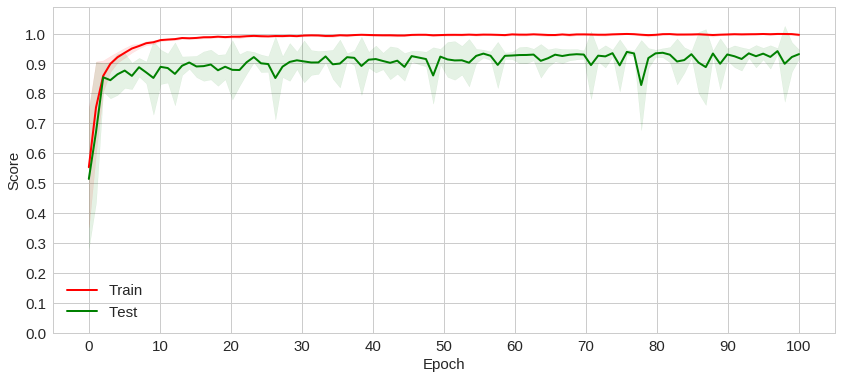

In [28]:
plot_mean_acc(history)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

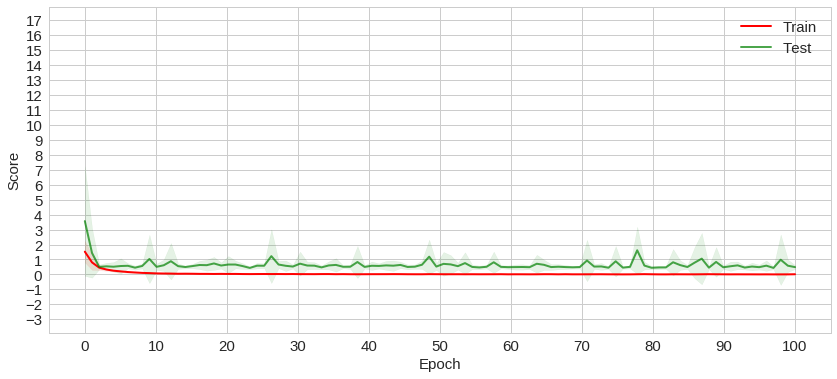

In [32]:
plot_mean_loss(history)